In [14]:
import numpy as np
import pandas as pd
import glob
import os
import sys
import matplotlib.pyplot as plt
import torch
import matplotlib.gridspec as gridspec
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

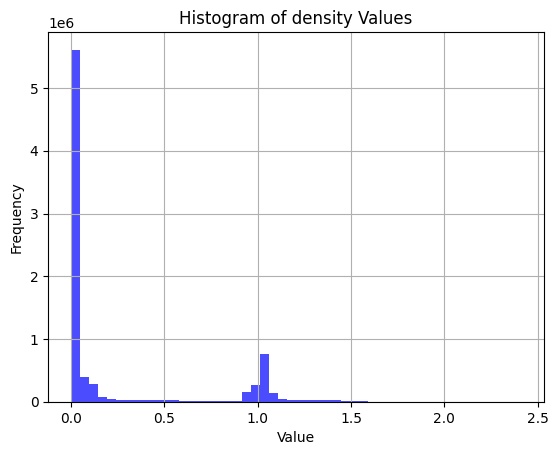

In [15]:
# Check the distribution of density matrix and decide which normalization to use.
density = np.load("/scratch/tappay01/densities/Data1.npy")

# Convert the tensor to a numpy array and flatten it
density_flat = density.flatten()

# Plot the histogram
plt.hist(density_flat, bins=50, color='blue', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of density Values')
plt.grid(True)
plt.show()

In [16]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from pathlib import Path
from typing import Tuple

from torch.utils.data import Subset
import glob


def to_voxel(position, axis):
    '''find voxel number as integer from position in mm. 
    Axis number representation 
    0 = z, 1 = y, 2 = x (beam)
    '''
    DELTA_Z = 2.5
    DELTA_X = 0.707031*2
    DELTA_Y = 0.707031*2
    if axis ==0:
        voxel = (position + 229) /DELTA_Z
    if axis ==1:
        voxel = (position + 181) /DELTA_Y
    if axis ==2:
        voxel = (position + 181) /DELTA_X
    return int(voxel) 


def extract_centered_subsample(data, z, y, x):
    half_z = 8  # half of 16
    half_y = 8  # half of 16
    sample = data[z-half_z:z+half_z, y-half_y:y+half_y, x[0]:x[1]]
    return sample

def extract_from_filename(filename, param):
    """Extracts energy value from the given filename."""
    parts = filename.split('_')
    if param == 'y':
        return int(parts[2][:-2])
    if param == 'z':
        return float(parts[3][:-6])
    if param == 'energy':
        return parts[1]
    else:
        return None

def find_watersim_in_folder(energy, folder):
    """Returns the path of the corresponding water simulation file based on the energy value."""
    target_filename = f"DATASET_{energy}.npy"
    return os.path.join(folder, target_filename)

def find_density_in_folder(dataset,y,z, folder):
    """Returns the path of the corresponding density file based on the dataset and source position value."""
    target_filename = f"{dataset}_{y}Mm_{z}Mm.npy"
    return os.path.join(folder, target_filename)



# Write a custom dataset class (inherits from torch.utils.data.Dataset)

class CustomDataset(Dataset):
    def __init__(self, data_folder, density_folder,water_folder, normalization='minmax'):
        x_range = [60, 188]
        
        self.data_samples = []
        self.density_samples = []

        self.data_names = []
        self.water_samples = []

        data_files = glob.glob(os.path.join(data_folder, "*.npy"))           
        print(data_folder)
        # Extract samples first without normalization
        for data_file in data_files:
            data = np.load(data_file)

            # Check if the data array is empty or has any zero dimension
            if data.size == 0 or 0 in data.shape:
                print(f"Invalid data file (empty or zero dimension): {data_file}")
                continue  # Skip the rest of the loop and go to the next file

            # Check if all values in the array are zero
            if np.all(data == 0):
                print(f"All values are zero in file: {data_file}")
                continue  # Skip the rest of the loop and go to the next file
            self.data_samples.append(data)  

            filename = os.path.basename(data_file) # Example "Data1_1500MeV_0Mm_-121.5Mm.npy"
            self.data_names.append(filename)

            dataset = filename.split('_')[0] # Example Data1, Data2
            y = extract_from_filename(filename, 'y')
            z = extract_from_filename(filename, 'z')  # Example y=0 and z=-121.5
            density = find_density_in_folder(dataset,y,z, density_folder)
            density_sample = np.load(density)
            self.density_samples.append(density_sample)


            energy = extract_from_filename(filename, 'energy')
            watersim_path = find_watersim_in_folder(energy, water_folder)
            if not os.path.exists(watersim_path):                
                print(f"Water simulation file not found for {energy}")
                watersim_path = find_watersim_in_folder('3000MeV', water_folder) #as default
            watersim = np.load(watersim_path)/10 #ratio of primary particles or histories (Water simulation n=10^8 and Phantom simulation n=10^7)
            water_sample= extract_centered_subsample(watersim, 80, 141, x_range)
            self.water_samples.append(water_sample)
            
        # Thresholding
        dose_threshold= 0.1# Set a threshold for values consider close to 0
        density_threshold = 1.5 # Set a threshold to limit outliers
        self.data_samples = [np.where(np.abs(sample) < dose_threshold, 0, sample) for sample in self.data_samples]
        self.water_samples = [np.where(np.abs(sample) < dose_threshold, 0, sample) for sample in self.water_samples]
        self.density_samples = [np.where(sample > density_threshold, density_threshold, sample) 
                        for sample in self.density_samples]
        
        # Normalize 
        all_data = np.array(self.data_samples)
        print(all_data.shape)
        all_density = np.array(self.density_samples)
        all_water = np.array(self.water_samples)
        if normalization == 'minmax':
            data_min = 0
            data_range = np.max(all_data) - data_min
            self.data_samples = [(sample - data_min) / data_range for sample in self.data_samples]
  
            density_min = np.min(all_density)
            density_range = np.max(all_density) - density_min
            self.density_samples = [(sample - density_min) / density_range for sample in self.density_samples]
            
            water_min = 0
            water_range = np.max(all_water) - water_min
            self.water_samples = [(sample - water_min) / water_range for sample in self.water_samples]

    def __len__(self):
        return len(self.data_samples)

    def __getitem__(self, idx):
        data_tensor = torch.tensor(self.data_samples[idx], dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        density_tensor = torch.tensor(self.density_samples[idx], dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        data_name = self.data_names[idx]
        water_tensor = torch.tensor(self.water_samples[idx], dtype=torch.float32).unsqueeze(0) 
        # Concatenate along the channel dimension
        condition = torch.cat([water_tensor, density_tensor], dim=0)
        
        return data_tensor, condition, water_tensor, density_tensor, data_name

In [17]:
import pickle
# Usage example:
saved_dataset = '/scratch/tappay01/custom_dataset.pkl'
#with open(saved_dataset, 'wb') as file:
#    pickle.dump(combined_dataset, file)
#Later, when you want to use the dataset again, you can load it from the file
with open(saved_dataset, 'rb') as file:
   combined_dataset = pickle.load(file)

In [18]:
BATCH_SIZE = 32 #To be 32 according to paper

In [19]:
from torch.utils.data import ConcatDataset, random_split
from torch.utils.data import DataLoader

print('Total data :',len(combined_dataset))
# Split combined dataset into train, validation, and test
train_size = int(0.8 * len(combined_dataset))
valid_size = int(0.1 * len(combined_dataset))
test_size = len(combined_dataset) - (train_size + valid_size)

train_subset, val_subset, test_subset = random_split(combined_dataset, [train_size, valid_size, test_size])

# Turn train, val and test custom Dataset into DataLoader's
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8) #creates 8 worker processes to load the data in parallel. 
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

print("Total number of samples in the train dataset:", len(train_subset))
print("Number of batches:", len(train_loader))
print("Total number of samples in the validation dataset:", len(val_subset))
print("Number of batches:", len(val_loader))
print("Total number of samples in the test dataset:", len(test_subset))
print("Number of batches:", len(test_loader))

Total data : 1122
Total number of samples in the train dataset: 897
Number of batches: 29
Total number of samples in the validation dataset: 112
Number of batches: 4
Total number of samples in the test dataset: 113
Number of batches: 4


In [20]:
# Get one batch from the loader
data_batch, condition_batch, water_batch, density_batch, data_name_batch = next(iter(val_loader))

# Print the shapes
print("Data batch shape:", data_batch.shape)
print("Condition batch shape:", condition_batch.shape)
print("Water batch shape:", water_batch.shape)
print("Density batch shape:", density_batch.shape)
print("Data name batch shape:", len(data_name_batch))

Data batch shape: torch.Size([32, 1, 16, 16, 128])
Condition batch shape: torch.Size([32, 2, 16, 16, 128])
Water batch shape: torch.Size([32, 1, 16, 16, 128])
Density batch shape: torch.Size([32, 1, 16, 16, 128])
Data name batch shape: 32


 Check if I correctly transformed the energies to dose is to calculate the sum of all doses in voxels of one water-image and compare it to the sum of all doses in voxels of the corresponding phantom-image. Since in either case the Carbon beam gets fully absorbed, the doses should be relatively equal.

!No. ???


In [21]:
for i in range(0,32):
    data_sample = data_batch[i, 0]
    print('data sample ', data_sample.shape, torch.min(data_sample).item(),  torch.max(data_sample).item())
for i in range(0,32):
    water_sample = water_batch[i, 0]
    print('water sample ',water_sample.shape, torch.min(water_sample).item(), torch.max(water_sample).item())

data sample  torch.Size([16, 16, 128]) 0.0 0.2899567186832428
data sample  torch.Size([16, 16, 128]) 0.0 0.3495522737503052
data sample  torch.Size([16, 16, 128]) 0.0 0.5368692874908447
data sample  torch.Size([16, 16, 128]) 0.0 0.3391549587249756
data sample  torch.Size([16, 16, 128]) 0.0 0.2643227279186249
data sample  torch.Size([16, 16, 128]) 0.0 0.8706302046775818
data sample  torch.Size([16, 16, 128]) 0.0 0.12565408647060394
data sample  torch.Size([16, 16, 128]) 0.0 0.24029938876628876
data sample  torch.Size([16, 16, 128]) 0.0 0.19069845974445343
data sample  torch.Size([16, 16, 128]) 0.0 0.3921326696872711
data sample  torch.Size([16, 16, 128]) 0.0 0.651622474193573
data sample  torch.Size([16, 16, 128]) 0.0 0.2607715129852295
data sample  torch.Size([16, 16, 128]) 0.0 0.28255629539489746
data sample  torch.Size([16, 16, 128]) 0.0 0.25315219163894653
data sample  torch.Size([16, 16, 128]) 0.0 0.6172294616699219
data sample  torch.Size([16, 16, 128]) 0.0 0.2749561369419098
data

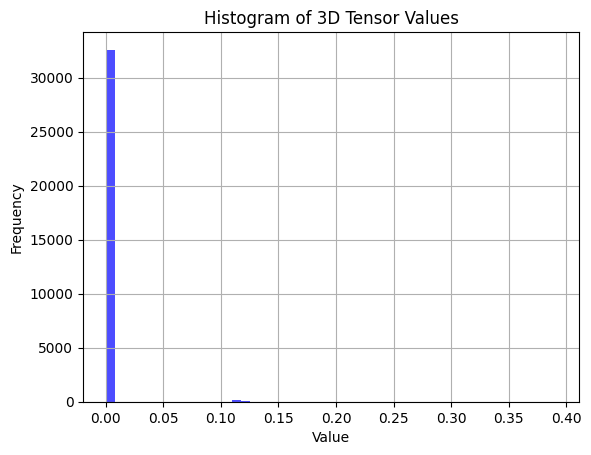

In [22]:
# Convert the tensor to a numpy array and flatten it
tensor_flat = water_sample.numpy().flatten()

# Plot the histogram
plt.hist(tensor_flat, bins=50, color='blue', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of 3D Tensor Values')
plt.grid(True)
plt.show()

In [23]:
def get_original_shape(cropped_data, filename):
    # Initialize the original tensor with zeros
    original_data = np.zeros((126, 256, 256))

    y = to_voxel(extract_from_filename(filename, 'y'), 1)
    z = to_voxel(extract_from_filename(filename, 'z'), 0)
    # Calculate the starting points
    start_x = 60
    start_y = y - 8
    start_z = z - 8
    
    # Calculate the ending points
    end_x = start_x + 128
    end_y = start_y + 16
    end_z = start_z + 16
    print('Z range:', start_z, "-", end_z)
    print('Y range:', start_y, "-", end_y)
    print('X range:', start_x, "-", end_x)
    # Assign values directly using tensor indexing
    original_data[start_z:end_z, start_y:end_y, start_x:end_x] = cropped_data
    

    return original_data

In [24]:
data_sample = data_batch[0, 0]
filename = data_name_batch[0]
filename

'Data4_2250MeV_-25Mm_-71.5Mm.npy'

In [25]:
def plot_brain(dose): #plot with shape zyx 126*256*256

    VOXELNUMBER_X = 256
    VOXELNUMBER_Y = 256
    VOXELNUMBER_Z = 126

    DELTA_Z = 2.5
    DELTA_X = 0.707031*2
    DELTA_Y = 0.707031*2

    x_vals = np.arange(-181, 181-DELTA_X, DELTA_X)
    x_vals = x_vals + DELTA_X/2

    y_vals = np.arange(-181, 181-DELTA_Y, DELTA_Y)
    y_vals = y_vals + DELTA_Y/2

    z_vals = np.arange(-229, 86-DELTA_Z, DELTA_Z) 
    z_vals = 1+ z_vals + DELTA_Z/2

    max_index = np.unravel_index(dose.argmax(), dose.shape)


    dose_x = []
    dose_y = []
    dose_z = []
    for x in range(VOXELNUMBER_X):
        dose_x.append(dose[int(max_index[0]), int(max_index[1]),x])        
    for y in range(VOXELNUMBER_Y):
        dose_y.append(dose[int(max_index[0]),y,int(max_index[2])])
    for z in range(VOXELNUMBER_Z):        
        dose_z.append(dose[z, int(max_index[1]),int(max_index[2])])
    del dose_z[0]
    # Create a 2x3 grid of subplots

    fig = plt.figure(figsize=(8, 3))
    gs = gridspec.GridSpec(1, 3, width_ratios=[0.7, 0.7, 1])  # 3 plots
    ax2 = plt.subplot(gs[2])
    ax2.plot(x_vals, dose_x)
    ax2.set_yscale('linear')
    ax2.set_xlabel('X [mm] (Beam direction)')
    #ax2.set_ylabel('Dose [Gy]')

    #axs[2].set_title('Dose Distribution in water along X direction')

    ax1 = plt.subplot(gs[1])
    ax1.plot(y_vals, dose_y)
    ax1.set_yscale('linear')
    ax1.set_xlabel('Y [mm]')
    #ax1.set_ylabel('Dose [Gy]')
    #axs[1].set_title('Dose Distribution in water along Y direction')

    ax0 = plt.subplot(gs[0])
    ax0.plot(z_vals, dose_z)
    ax0.set_yscale('linear')
    ax0.set_xlabel('Z [mm]')
    ax0.set_ylabel('Normalized dose')
    ax0.set_title('Dose in head phantom at beam center : ('+ filename +')')
    #axs[0].set_title('Dose Distribution in water along Z direction')

    
    plt.tight_layout()
    plt.show()  

In [26]:
plot_brain(original_tensor)

NameError: name 'original_tensor' is not defined

In [ ]:
dose = np.load('/scratch/tappay01/data/data1/Data1_3000MeV_0.1Mm_-96.5Mm.npy')
plot_brain(dose)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/tappay01/data/data1/Data1_3000MeV_0.1Mm_-96.5Mm.npy'

In [4]:
import numpy as np 
watersim = np.load("/scratch/tappay01/watersimulation/DATASET/DATASET_4000MeV.npy")
print(watersim.shape)
max_index = np.unravel_index(watersim.argmax(), watersim.shape)
print(max_index)


(160, 283, 283)
(80, 141, 208)


In [27]:
z=80
y =141 

half_z = 8  # half of 16
half_y = 8


sample = watersim[z-half_z:z+half_z, y-half_y:y+half_y, 60:188]
sample.shape

(16, 16, 128)

In [31]:
(60+188)*0.5

124.0

After bring back to original shape, there will be difference at the edge outside the cropped voxel. So the passing rate should only be calculate between the cropped voxel of simulated dose and generated dose.

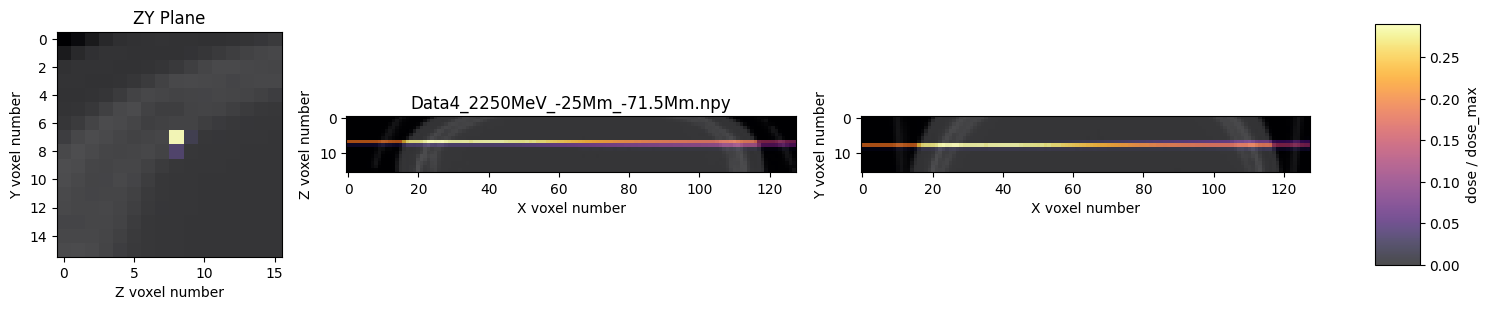

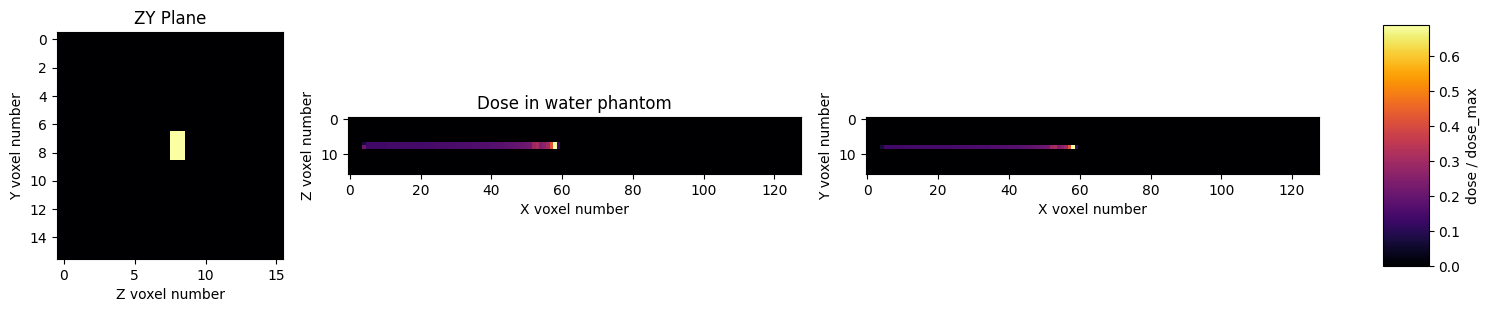

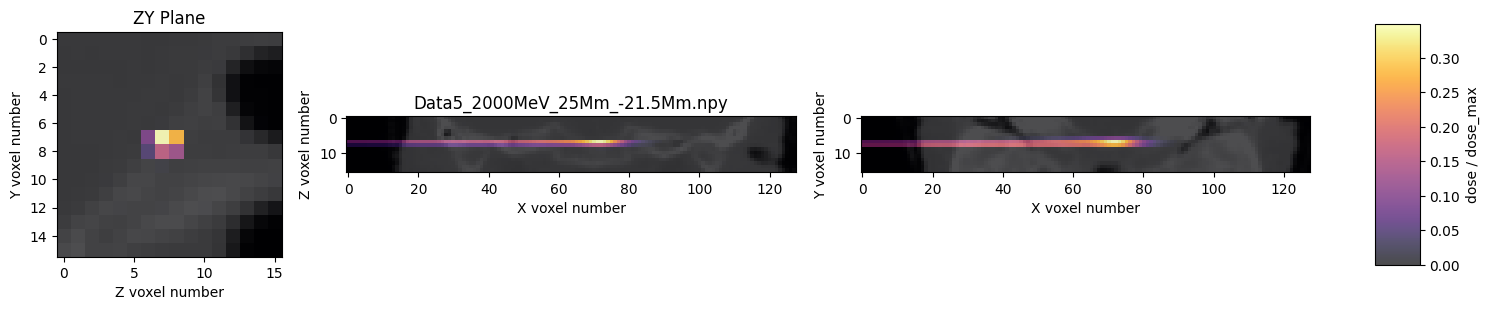

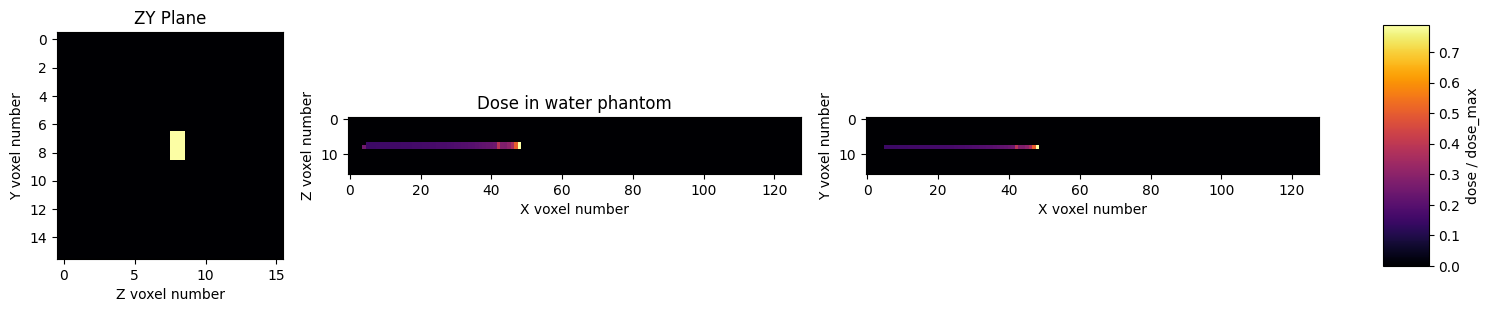

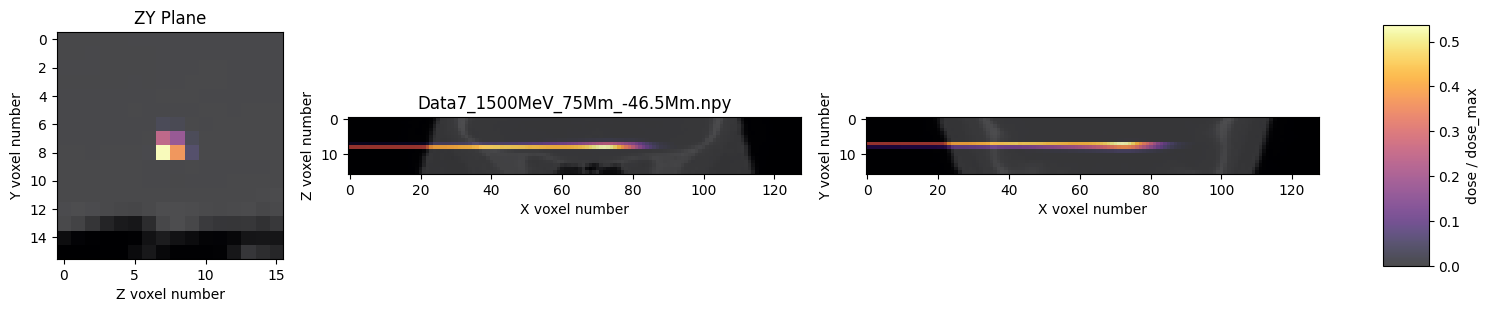

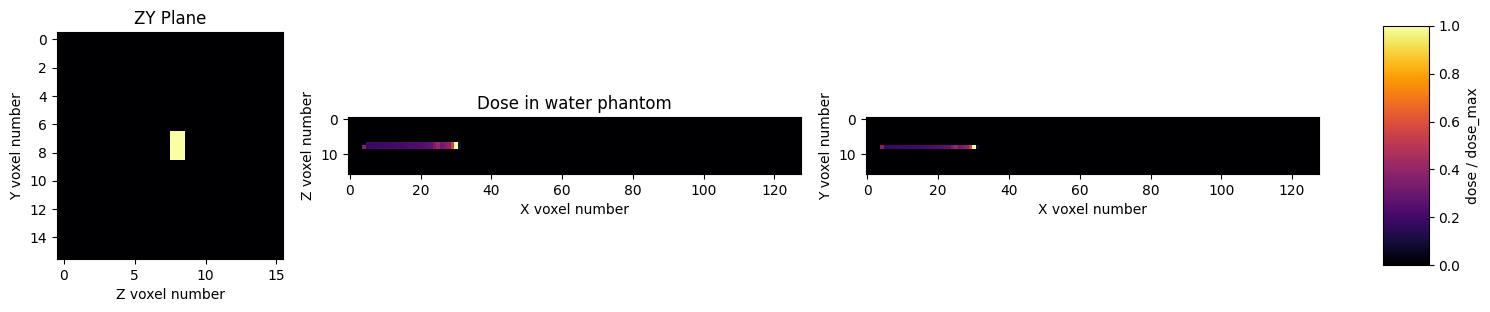

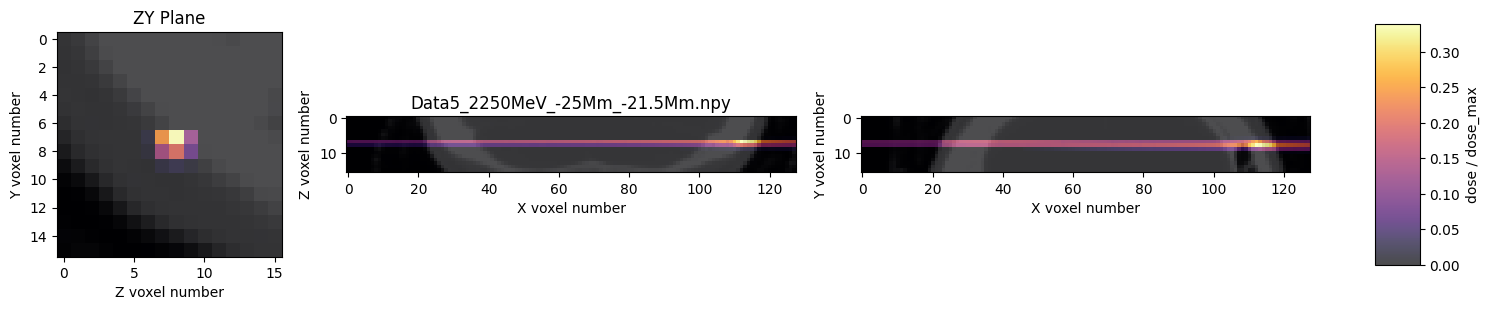

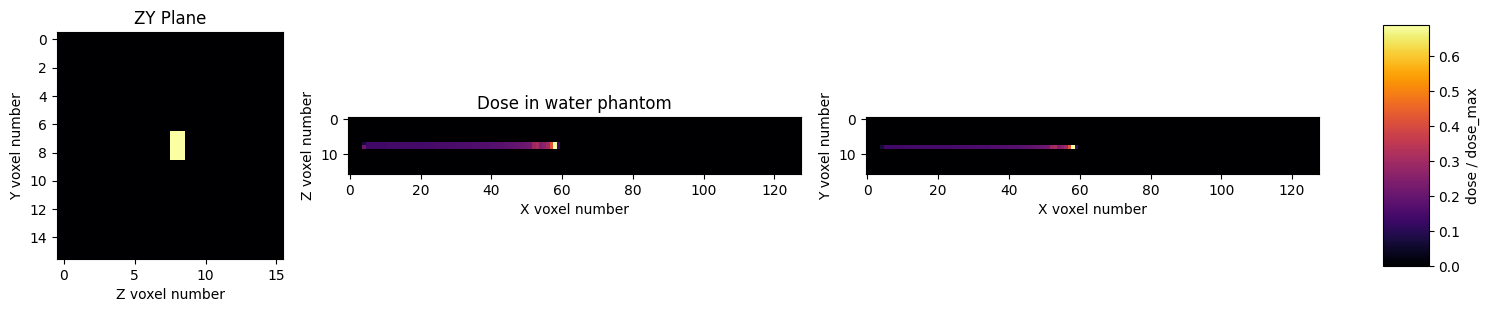

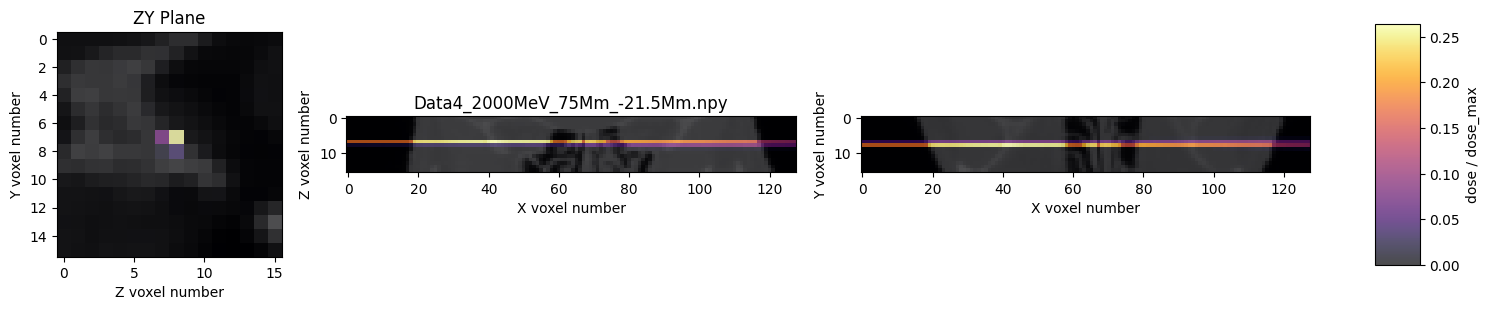

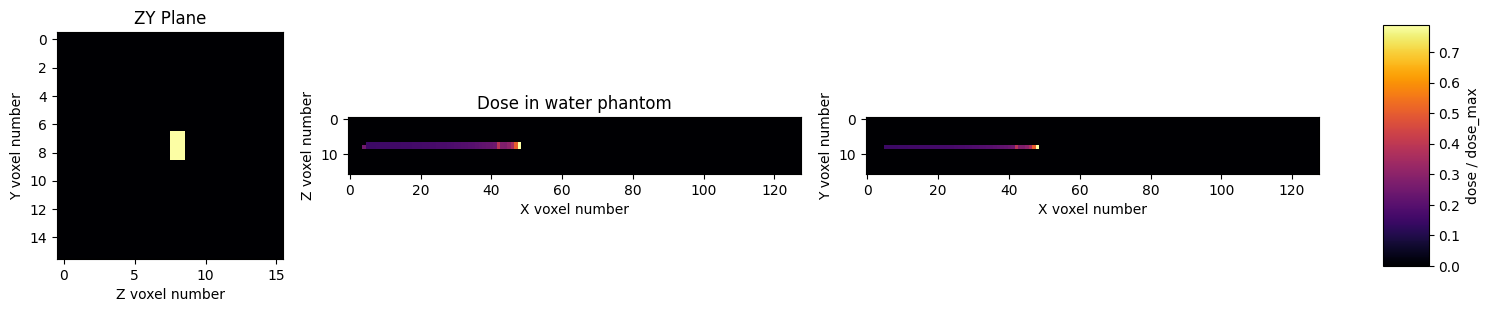

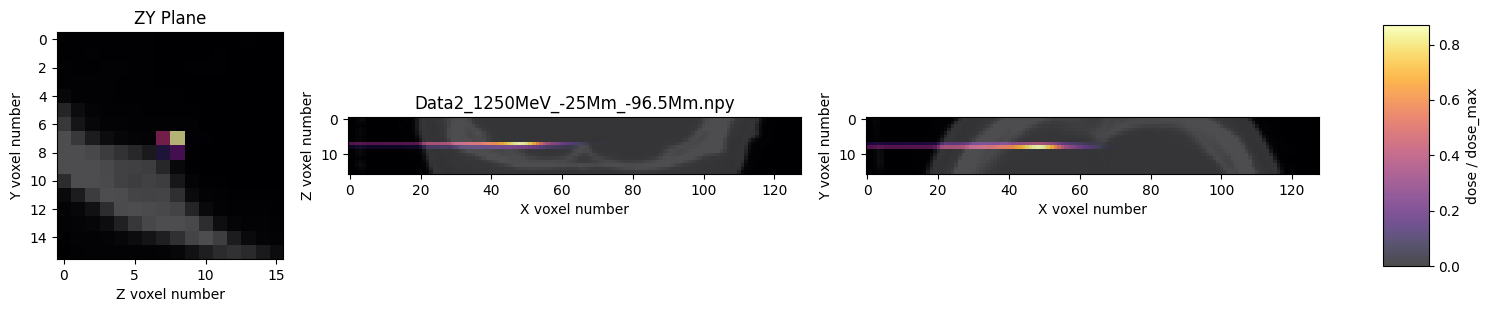

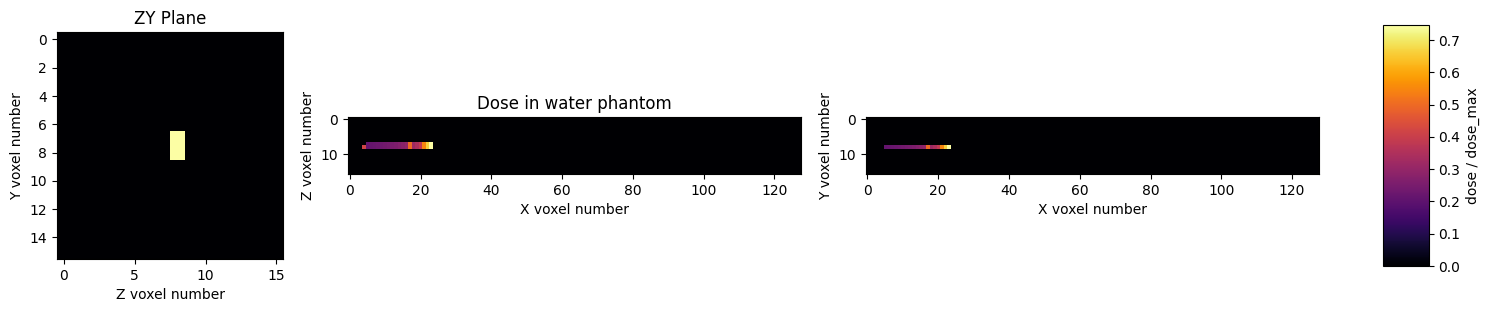

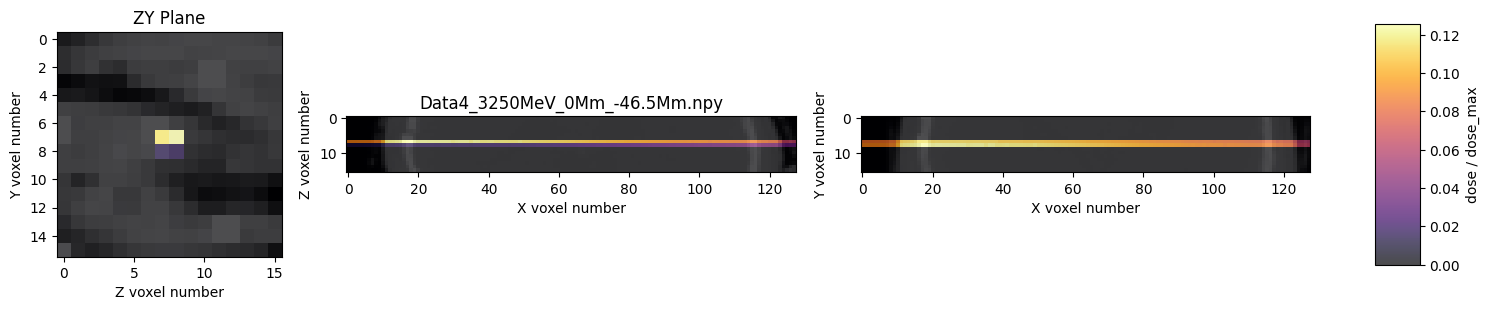

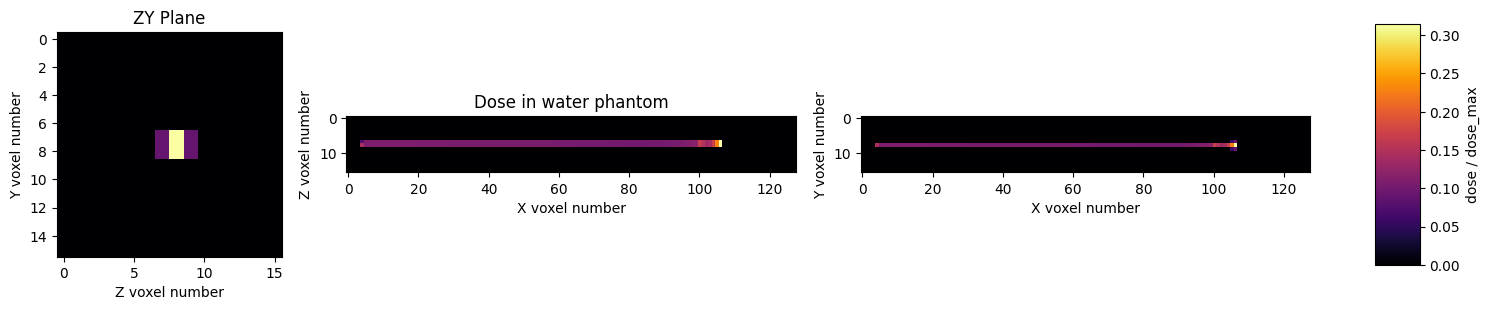

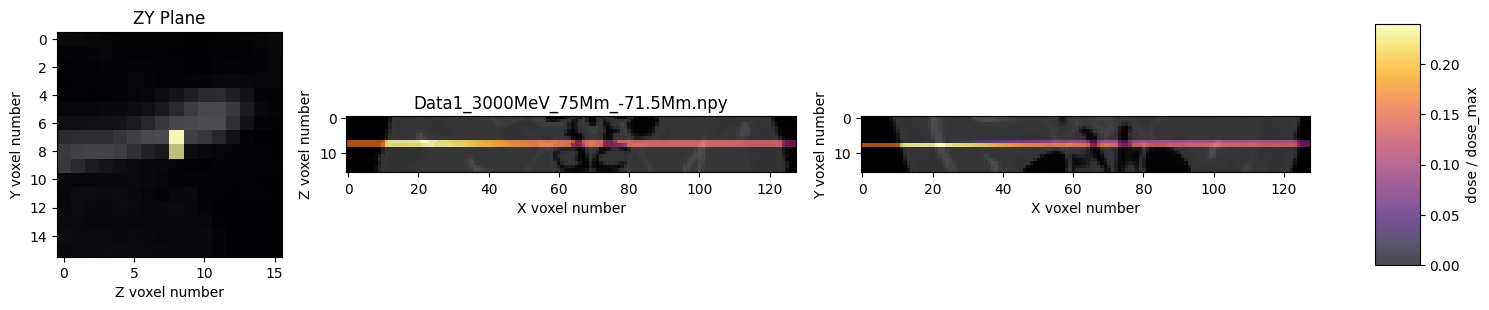

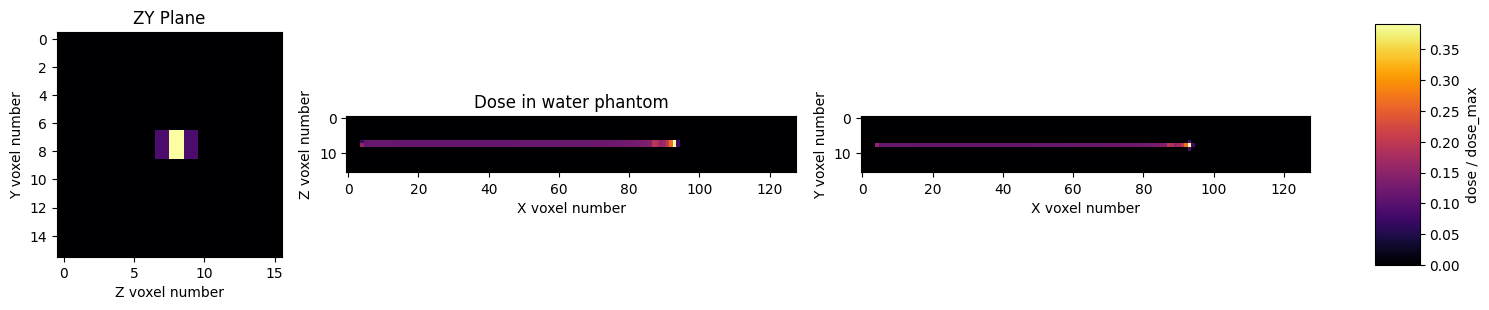

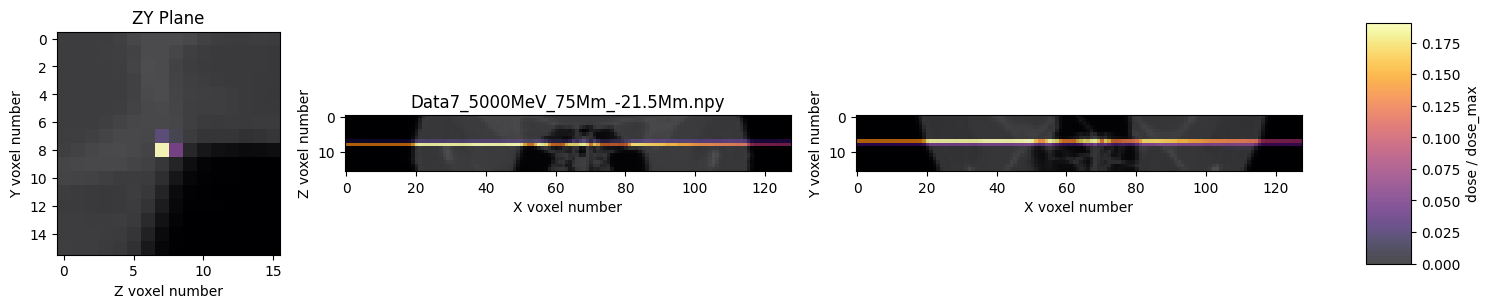

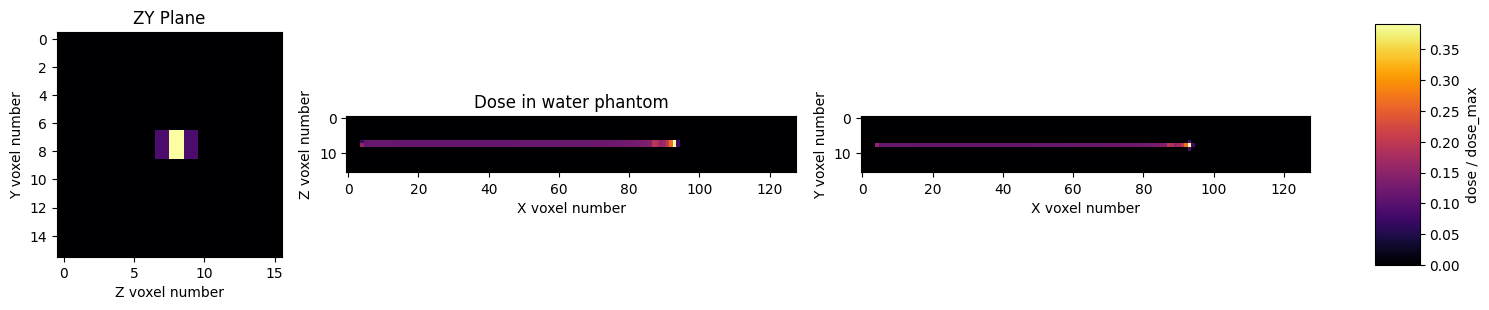

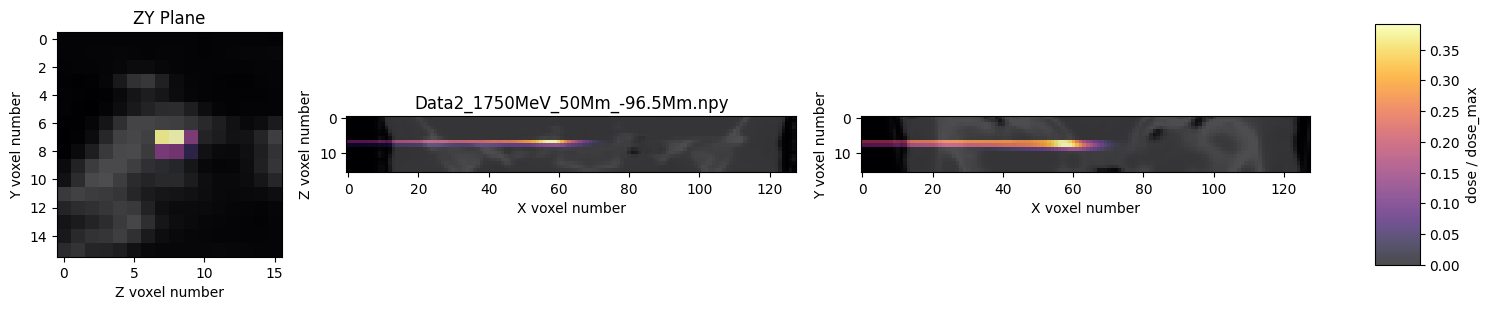

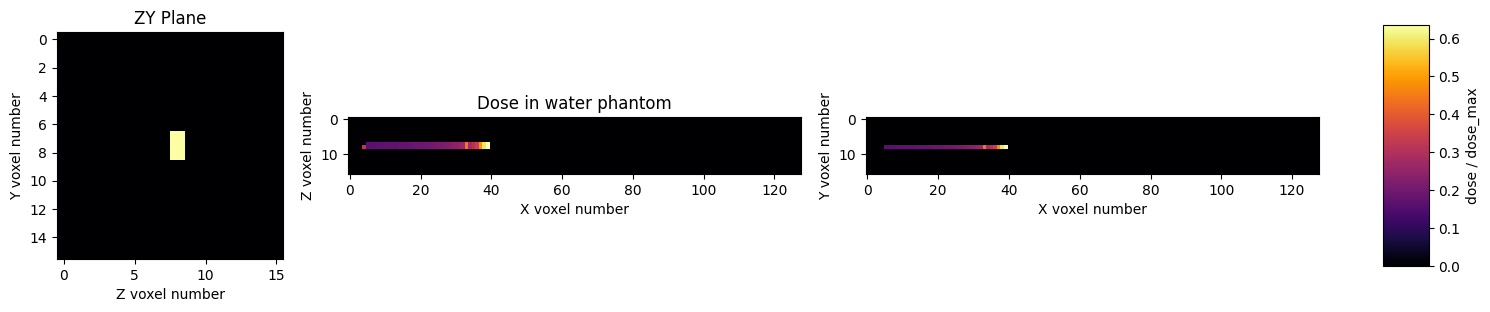

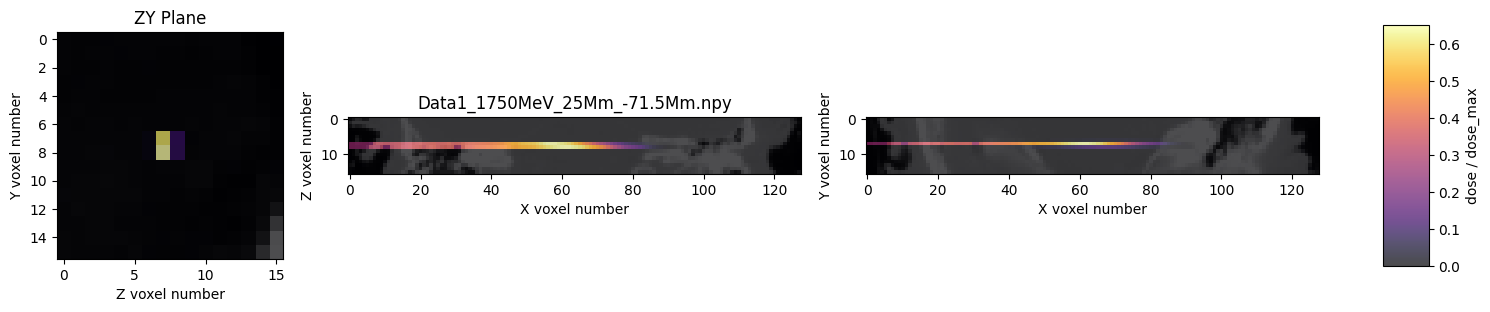

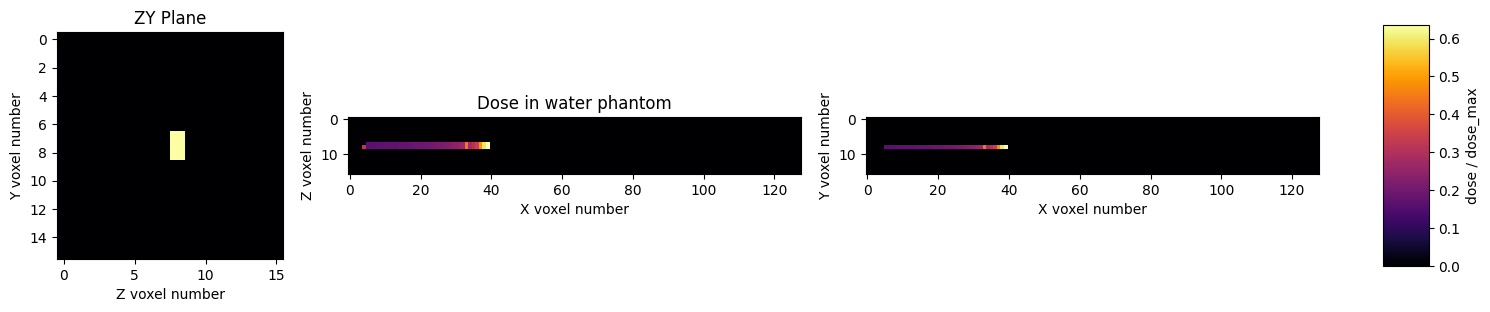

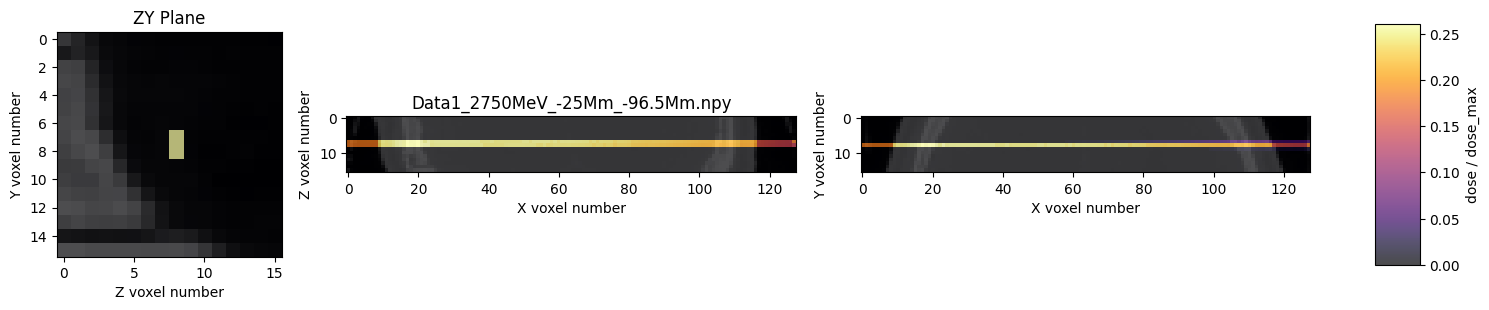

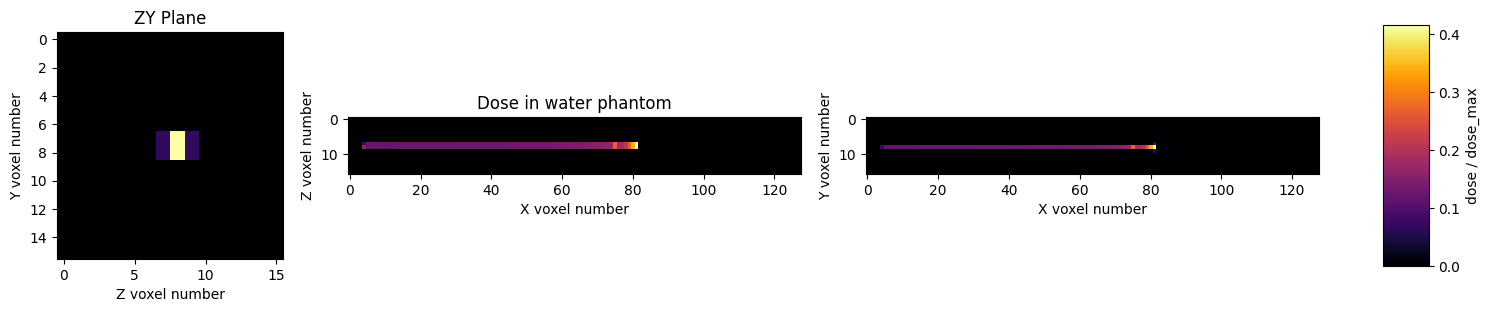

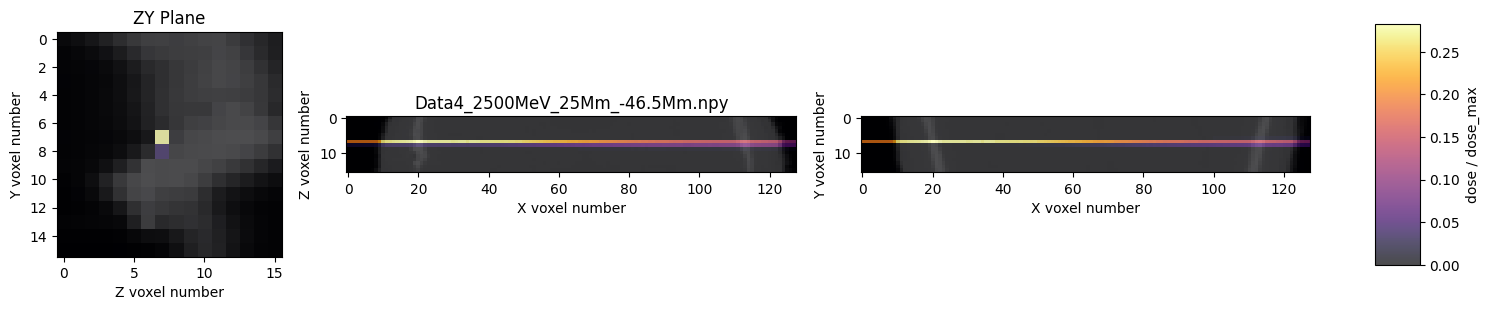

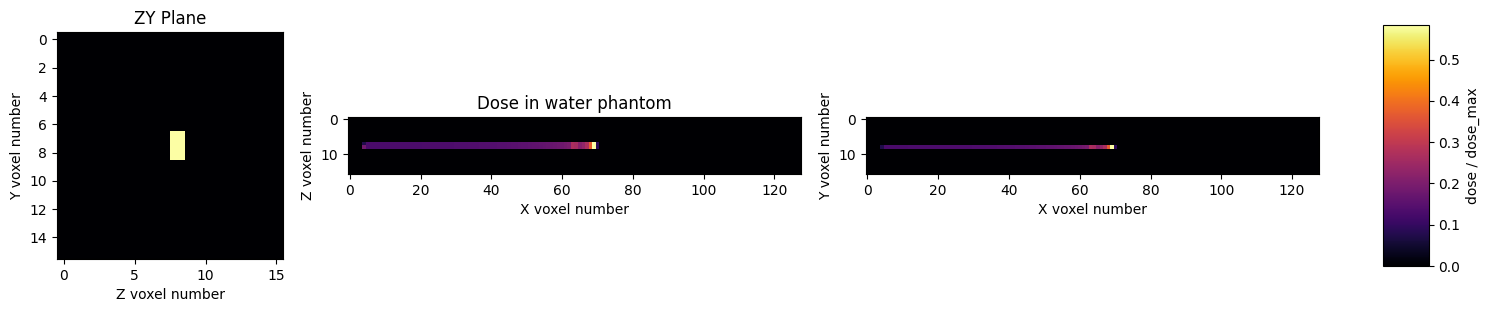

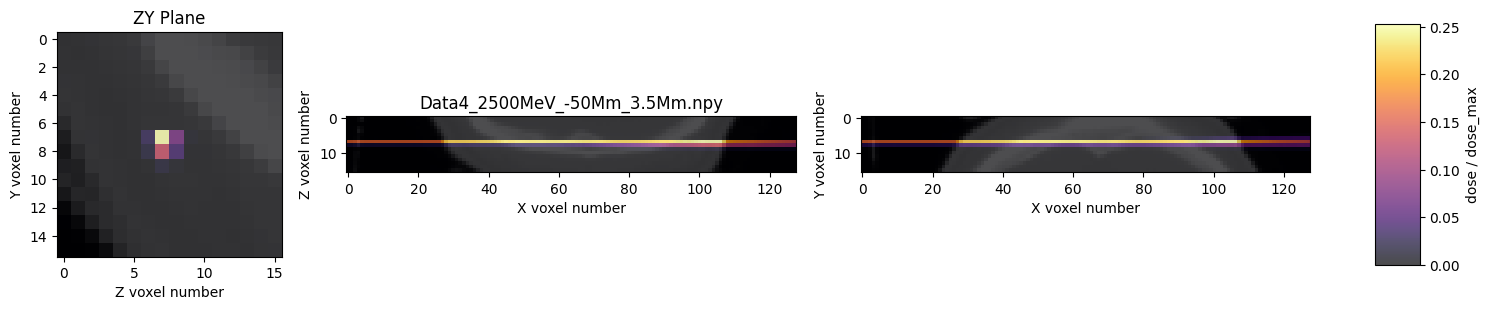

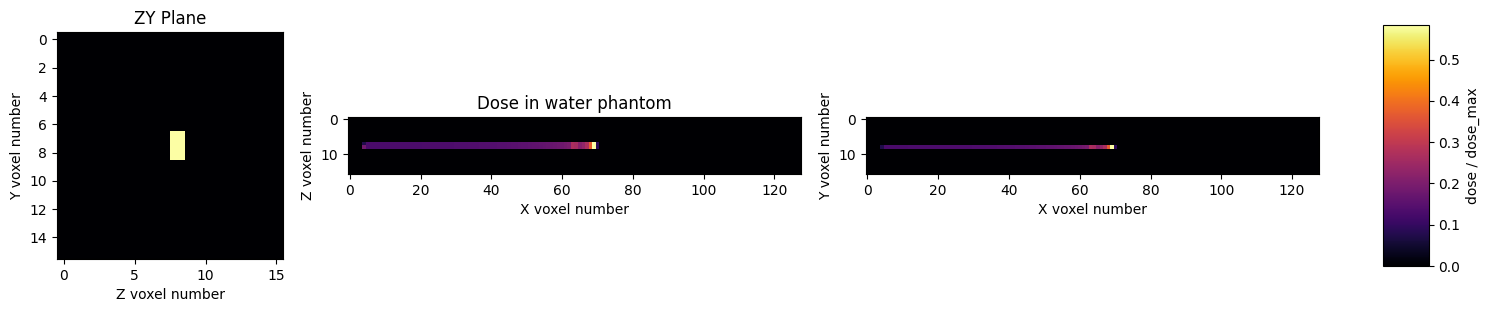

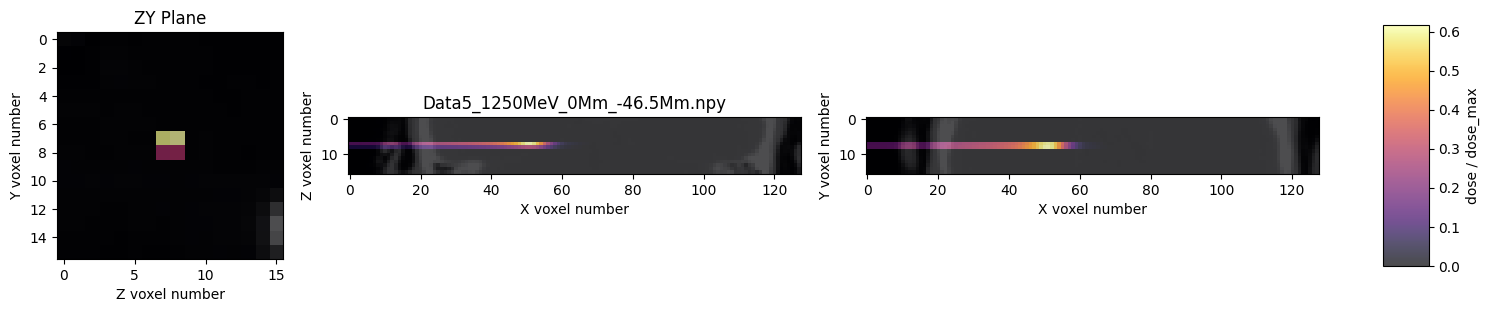

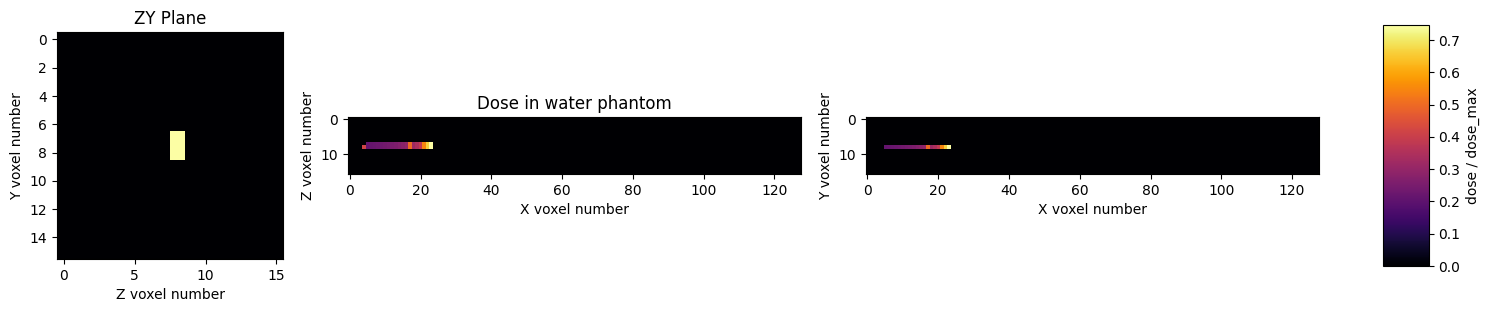

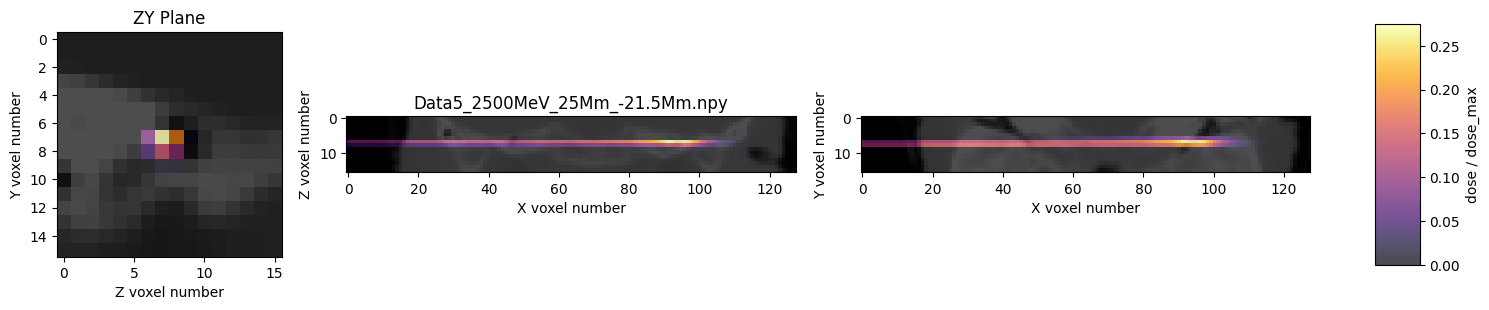

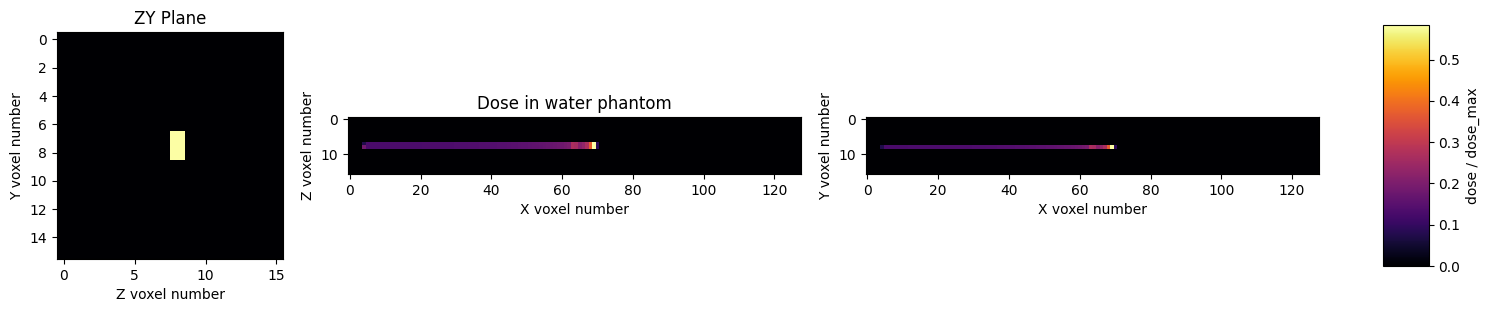

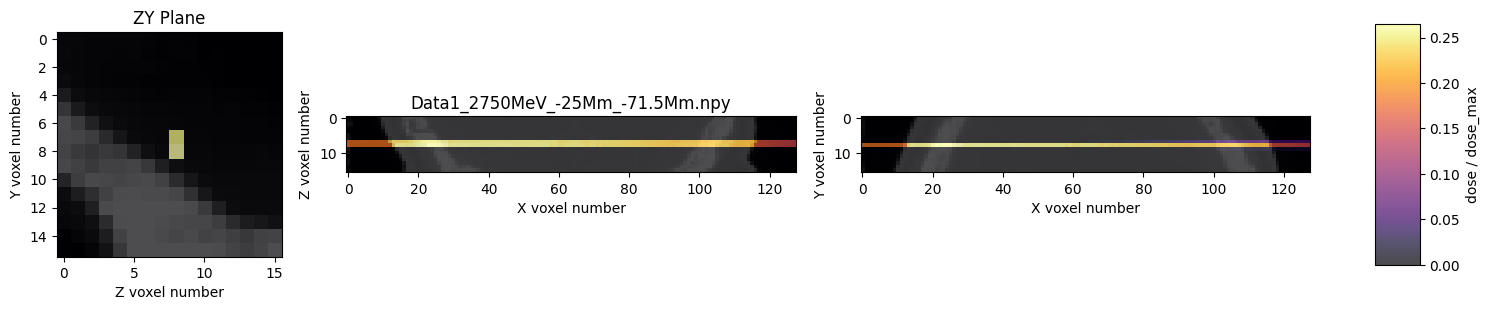

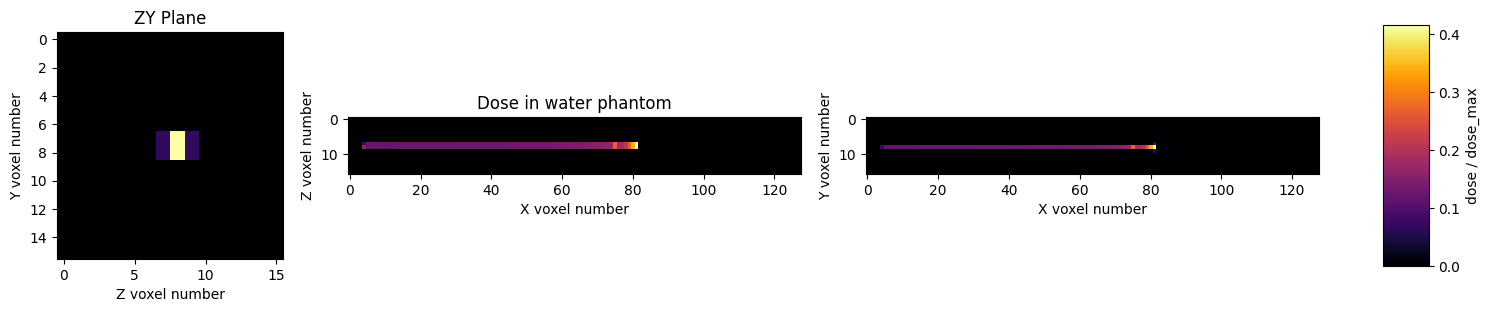

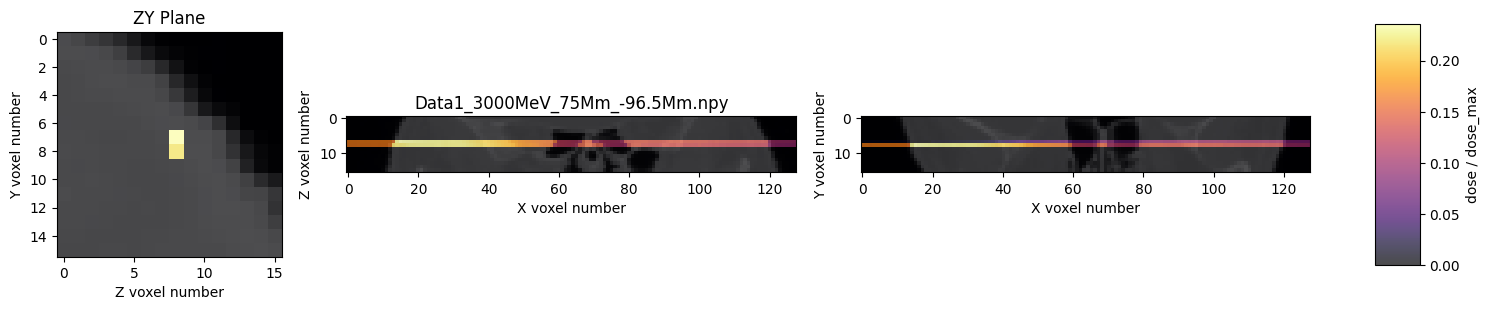

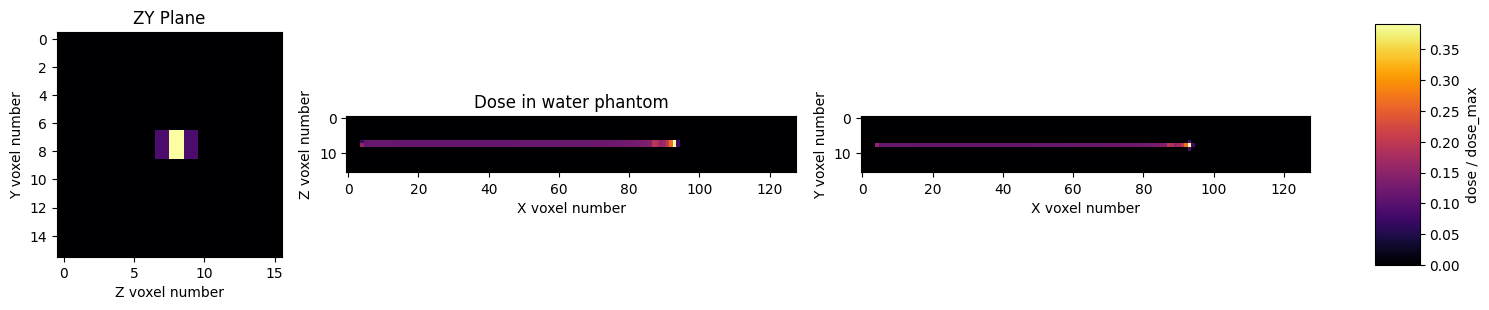

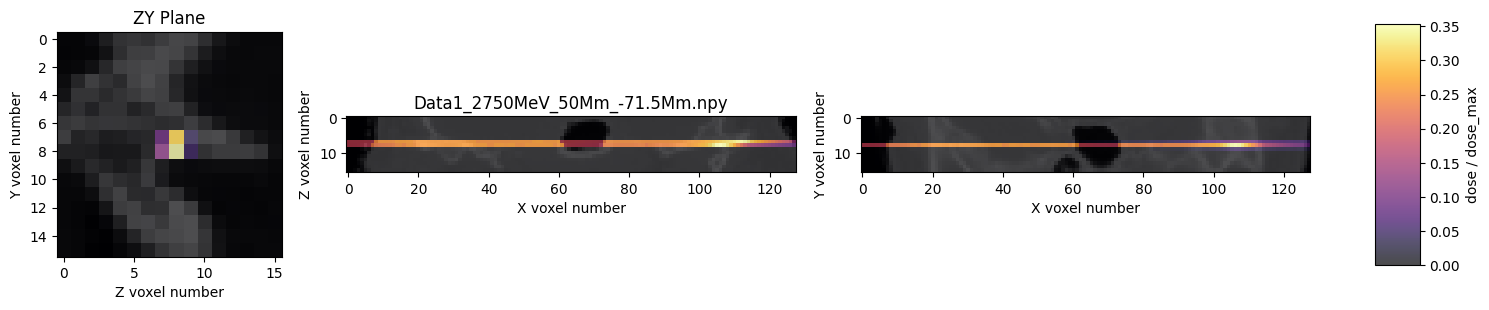

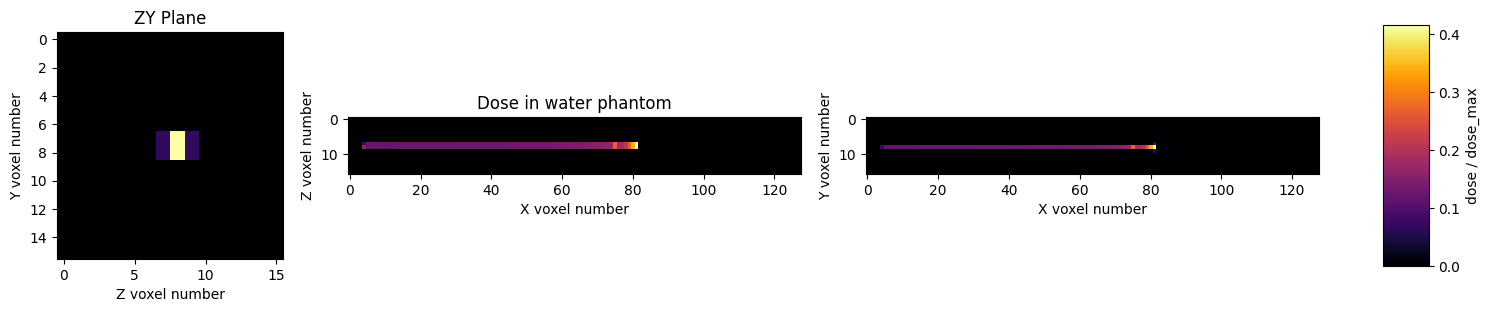

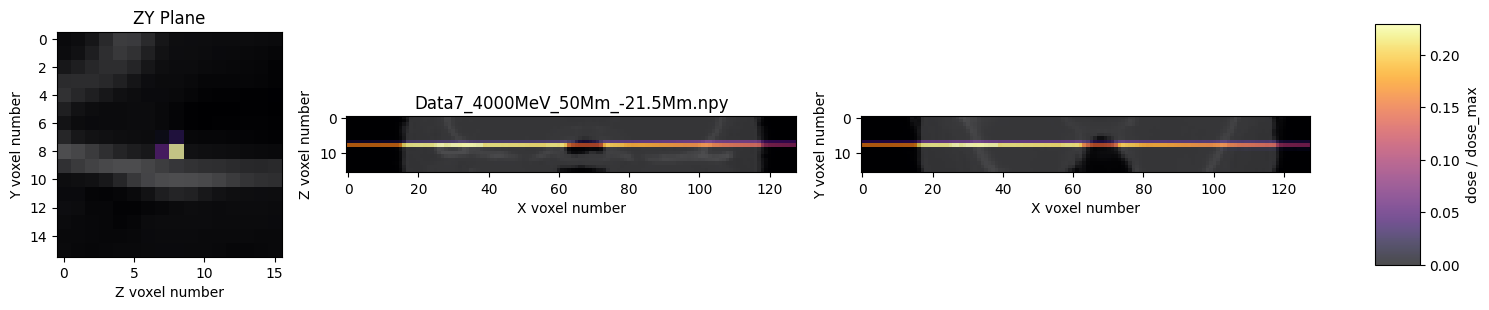

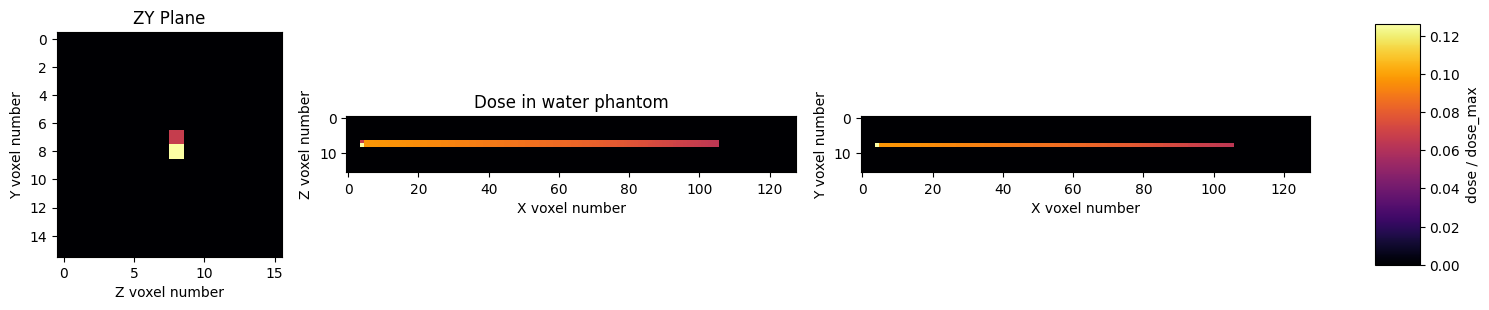

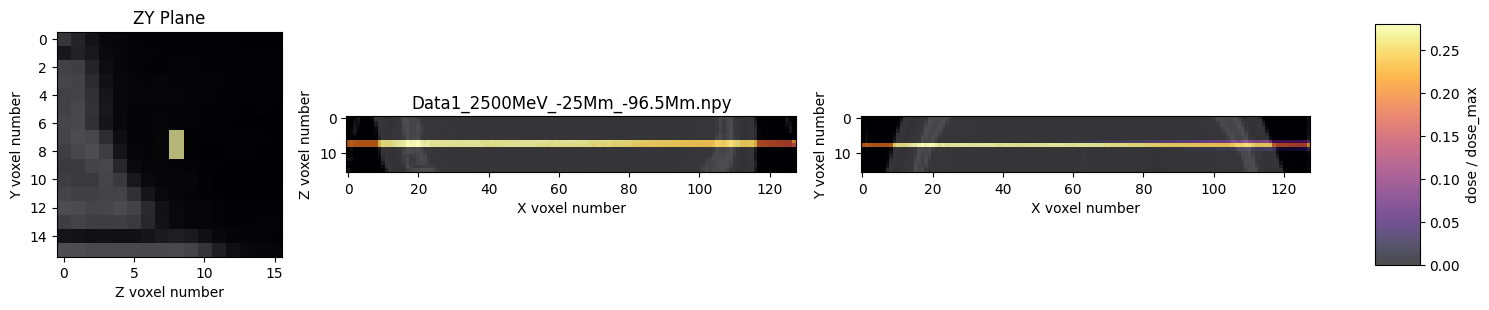

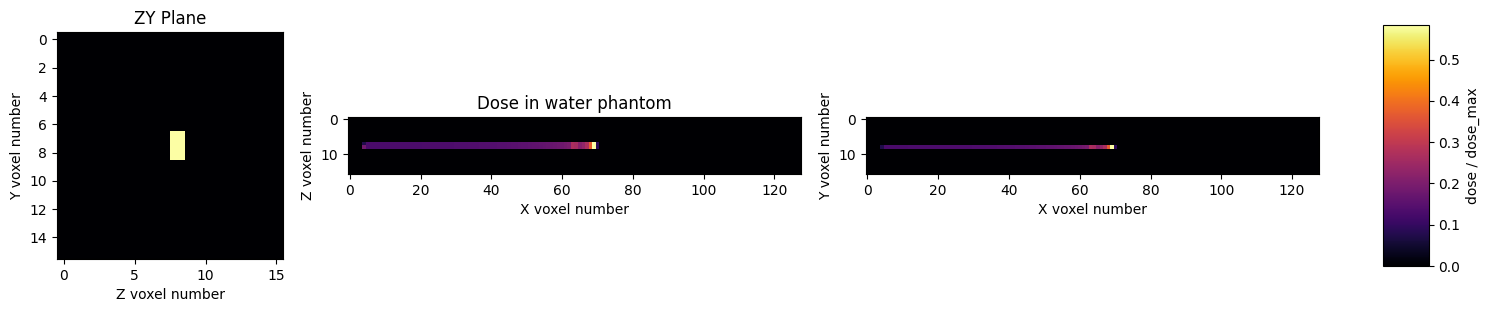

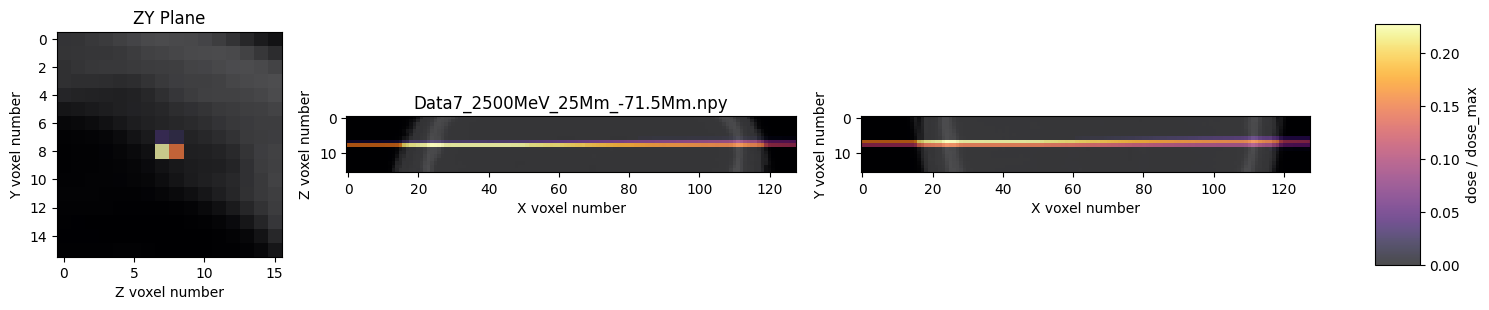

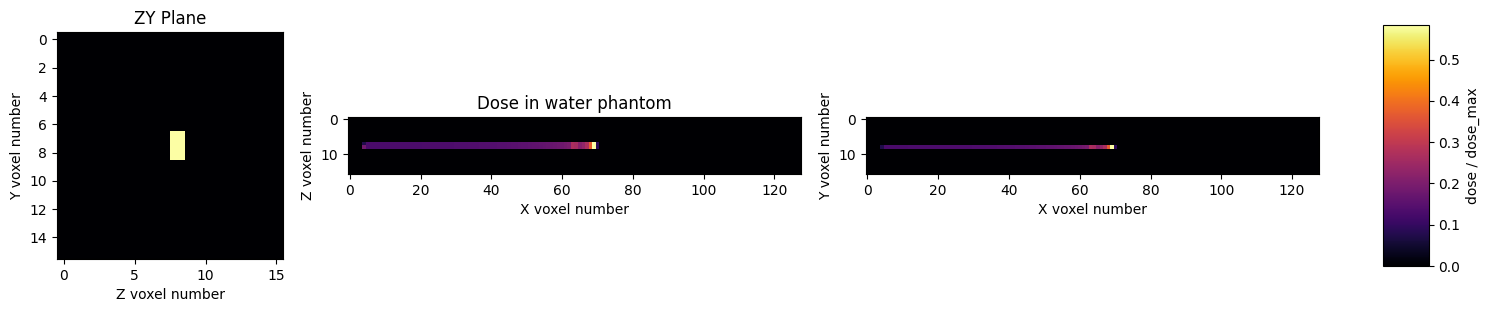

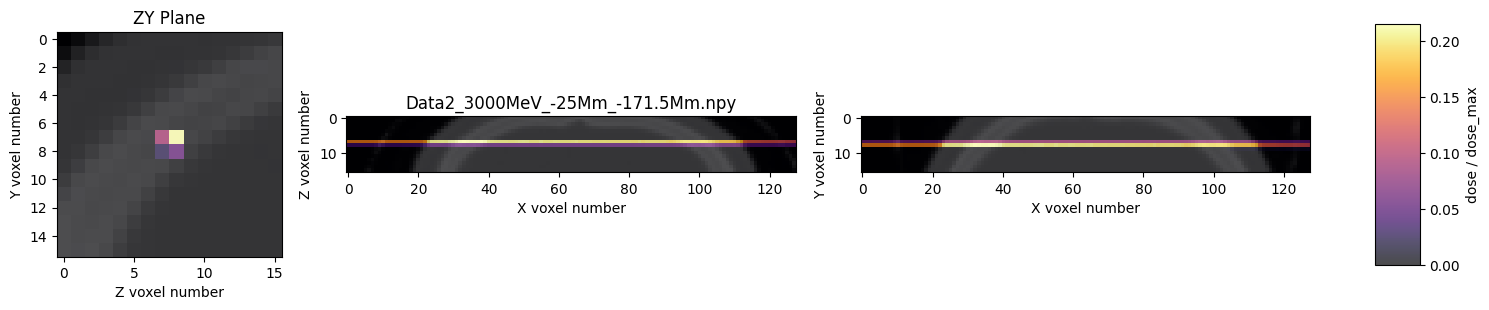

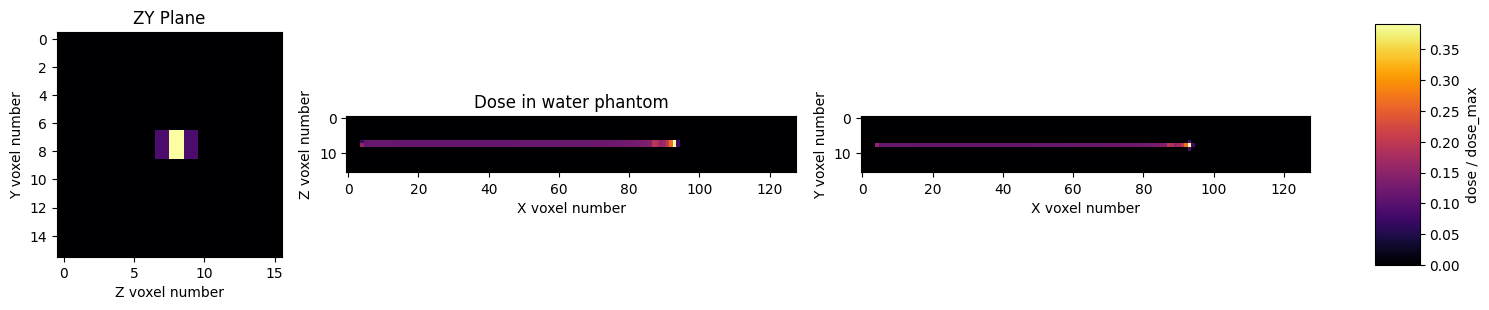

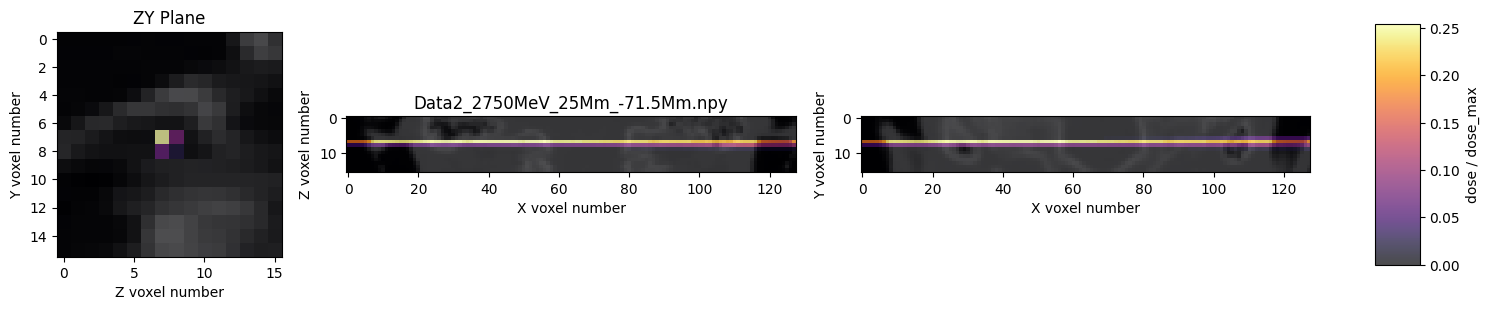

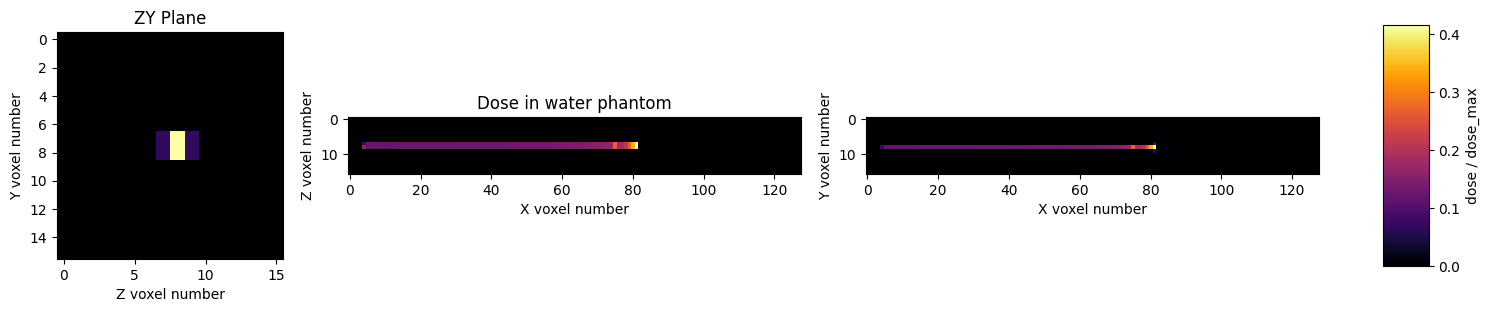

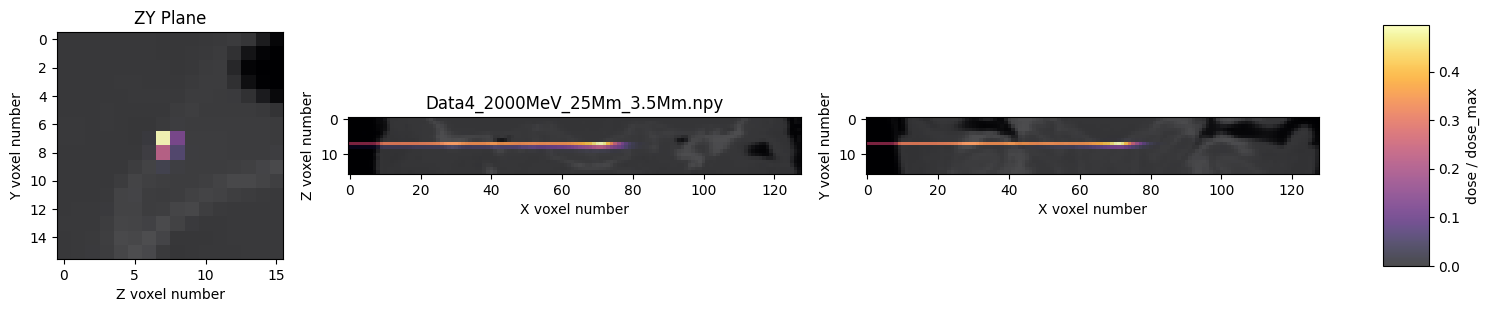

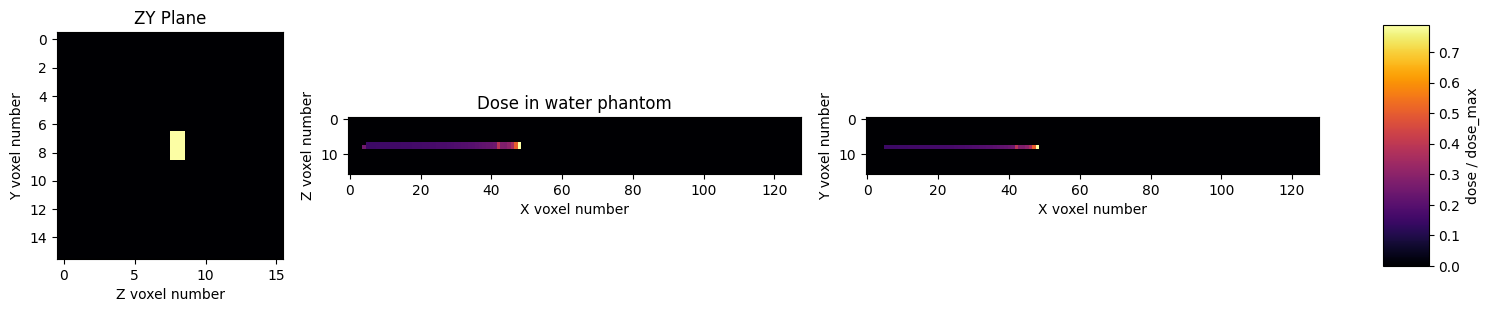

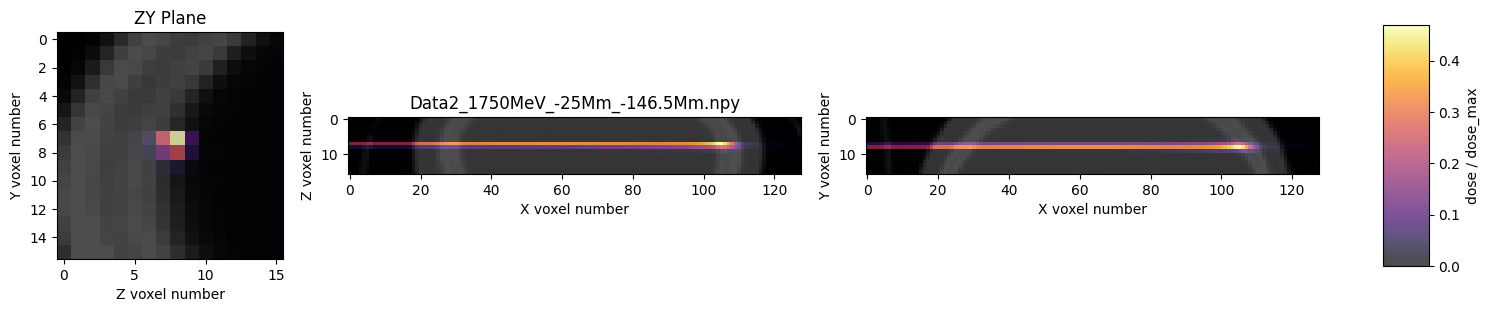

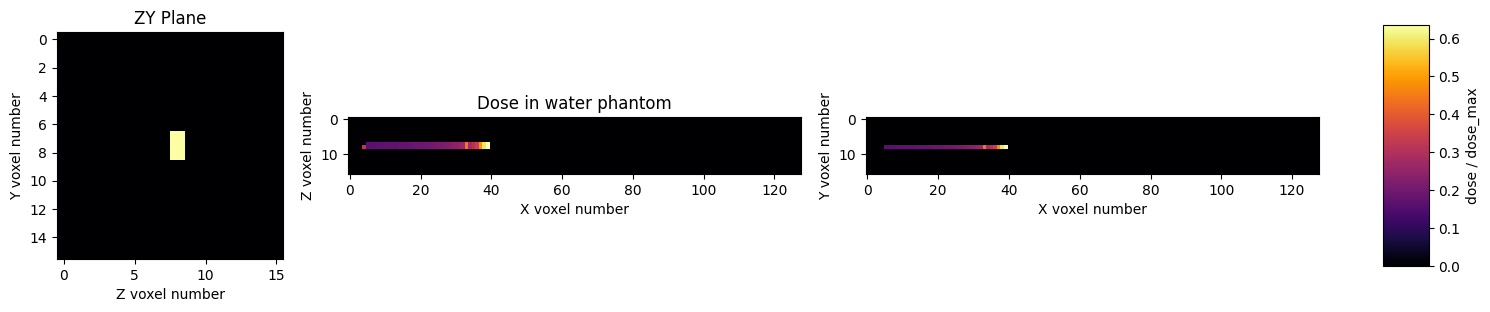

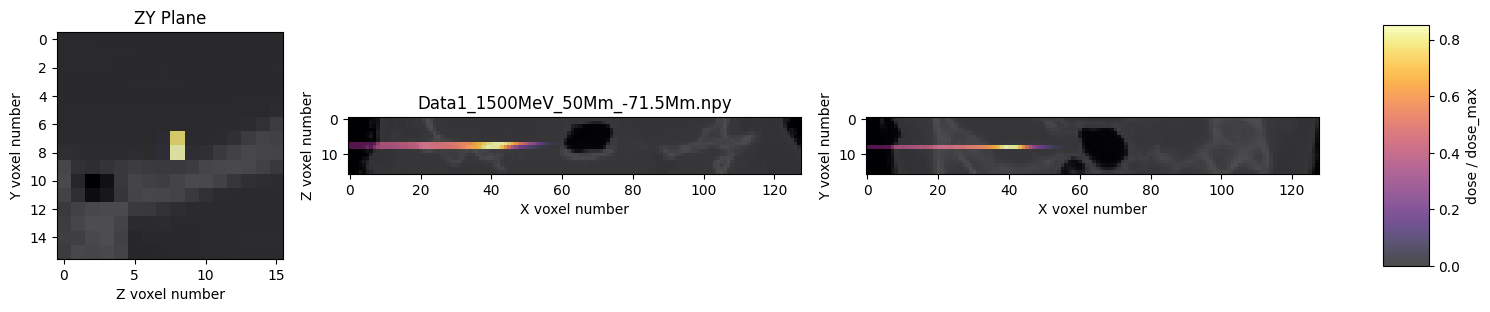

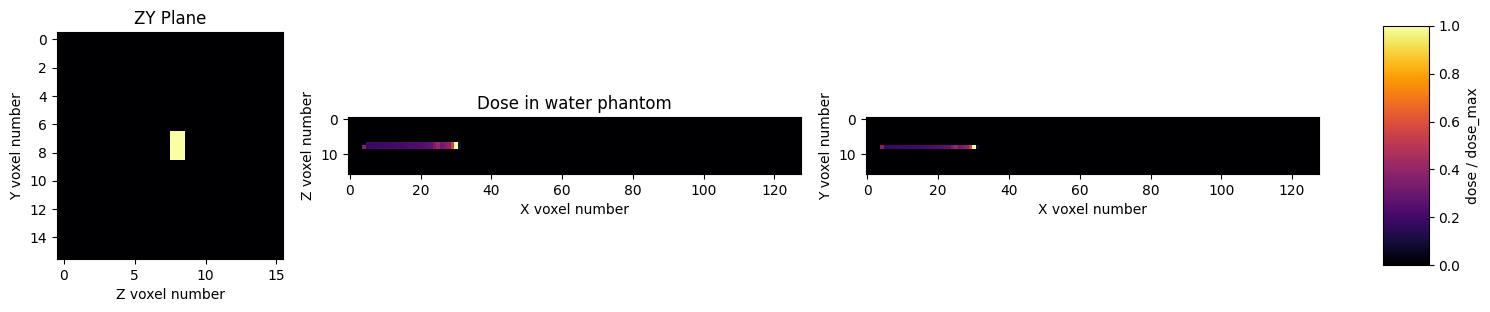

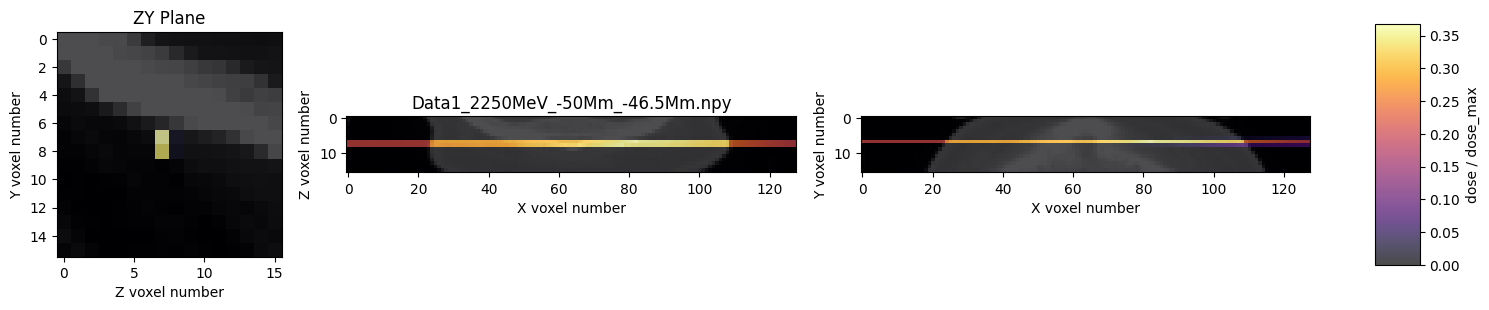

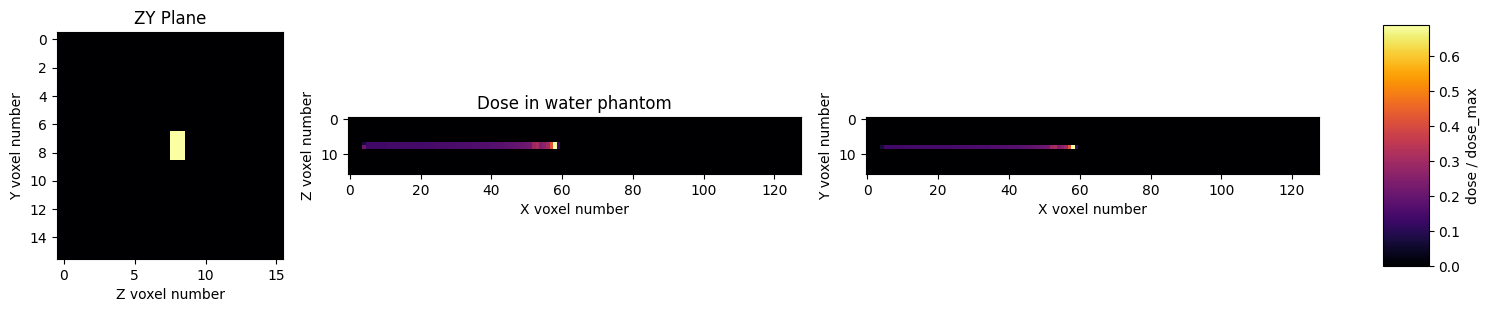

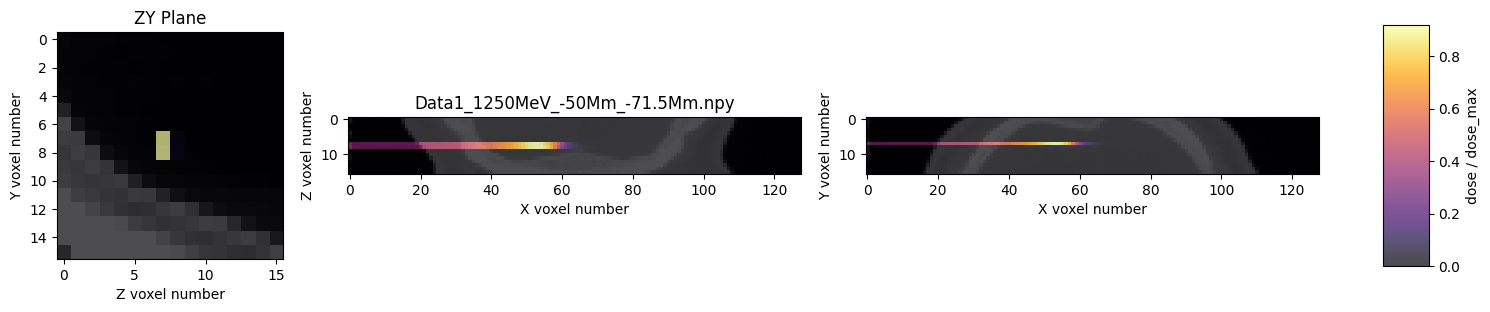

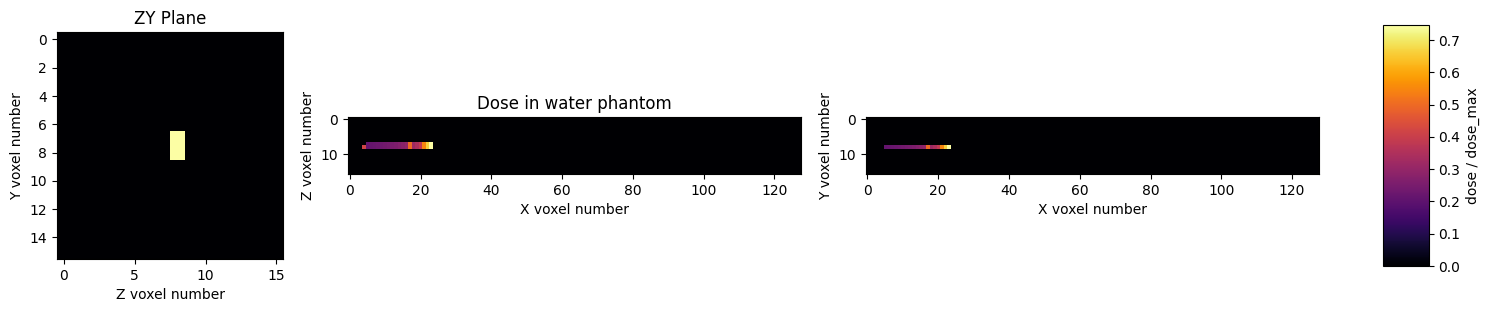

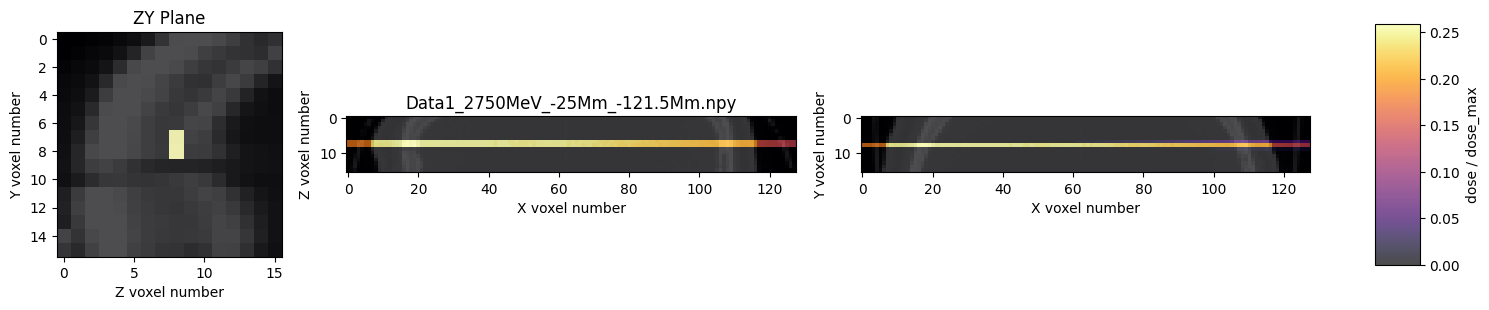

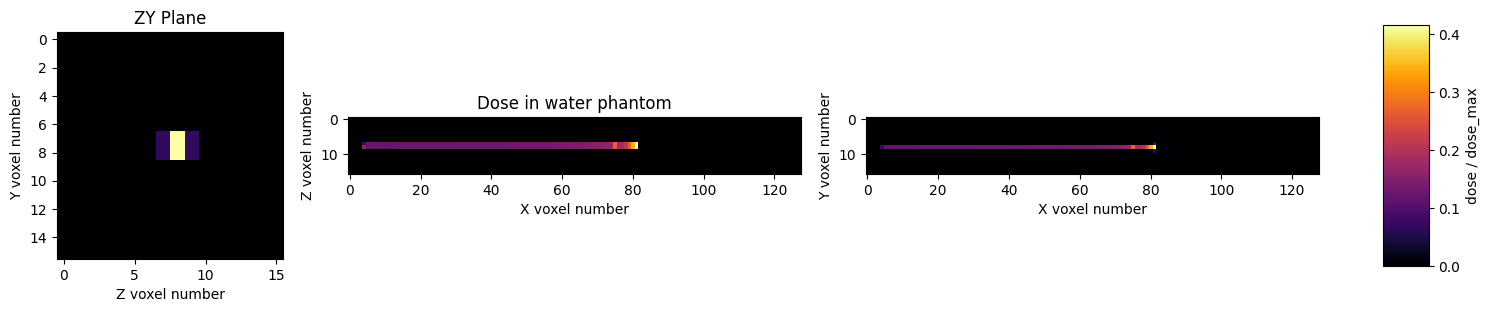

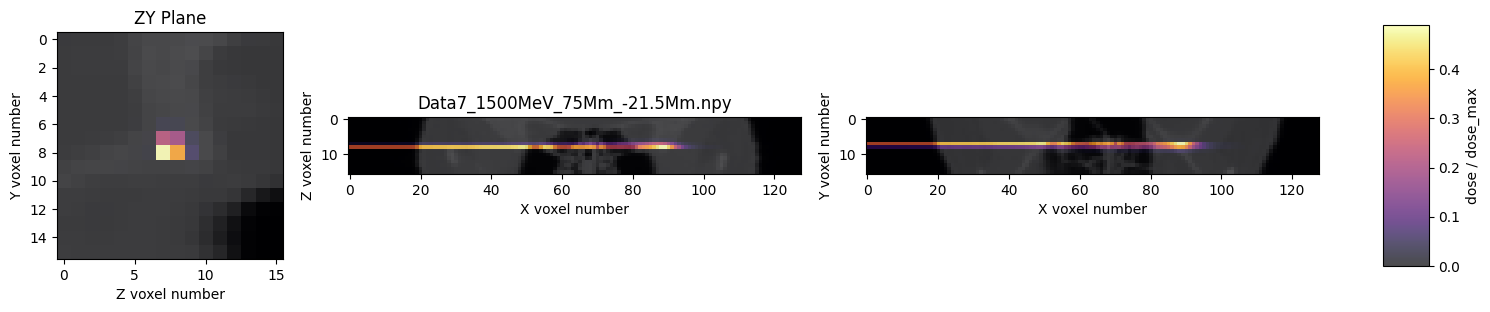

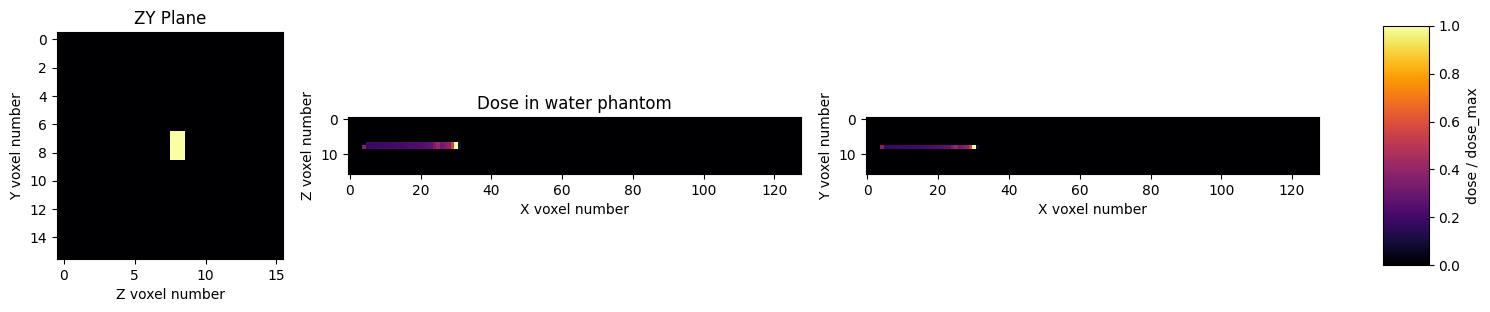

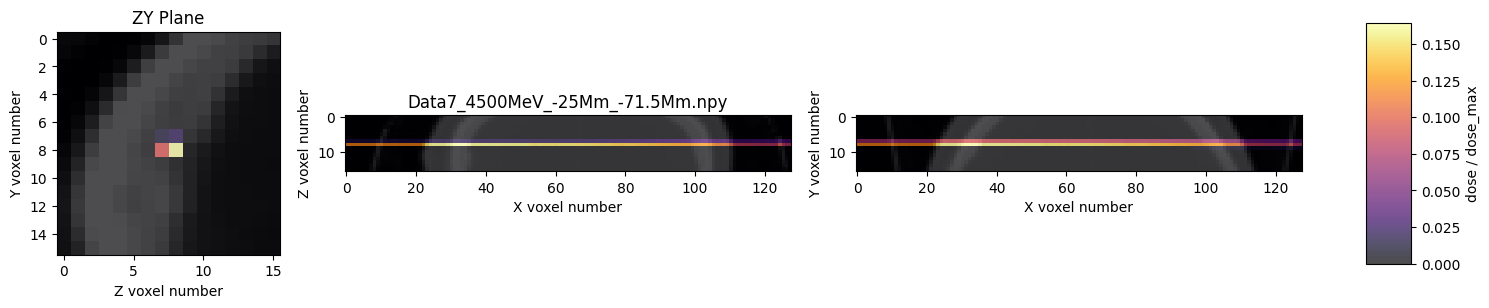

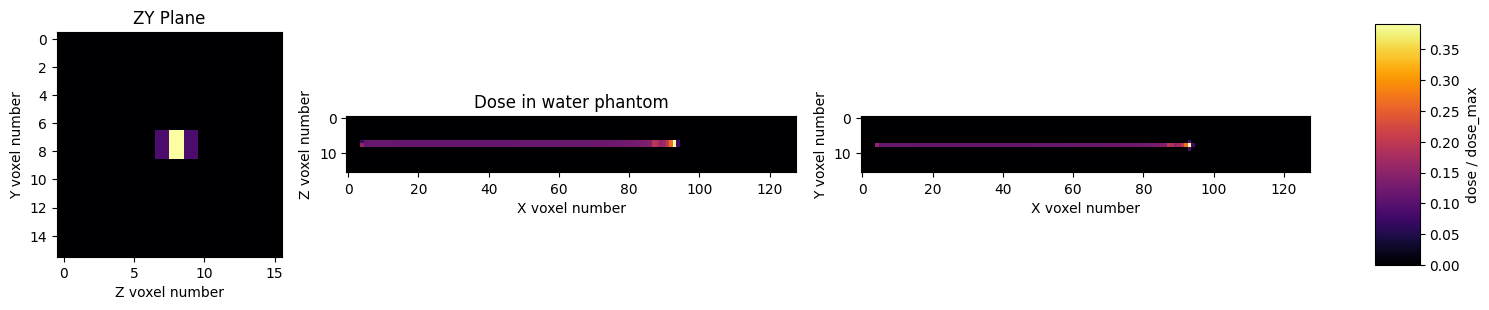

In [30]:
import torch
import matplotlib.pyplot as plt

# Define center of the volume
center = [7,7] # z,y
# Define number of samples
n_samples = data_batch.shape[0]

for i in range(n_samples):
    data_sample = data_batch[i, 0]
    density_sample = density_batch[i, 0]
    data_name_sample = data_name_batch[i]
    # Define the figure and the grid
    fig = plt.figure(figsize=(15, 3))
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 2, 2, 0.2])  # 3 plots + 1 colorbar
    max_index = np.unravel_index(data_sample.argmax(), data_sample.shape)
        
    # ZY plane
    ax0 = plt.subplot(gs[0])
    ax0.imshow(density_sample[:, :, max_index[2]], cmap='gray')
    ax0.imshow(data_sample[:, :,max_index[2]], cmap='inferno', alpha=0.7)
    ax0.set_title("ZY Plane")
    ax0.set_xlabel('Z voxel number')
    ax0.set_ylabel('Y voxel number')

    # ZX plane
    ax1 = plt.subplot(gs[1])
    ax1.imshow(density_sample[:, center[1], :], cmap='gray')
    ax1.imshow(data_sample[:, max_index[1], :], cmap='inferno', alpha=0.7)
    ax1.set_title(data_name_sample)
    ax1.set_xlabel('X voxel number')
    ax1.set_ylabel('Z voxel number')

    # YX plane
    ax2 = plt.subplot(gs[2])
    ax2.imshow(density_sample[center[0], :, :], cmap='gray')
    img_data = ax2.imshow(data_sample[max_index[0], :, :], cmap='inferno', alpha=0.7)
    ax2.set_xlabel('X voxel number')
    ax2.set_ylabel('Y voxel number')

    # Colorbar
    cax = plt.subplot(gs[3])
    cbar = plt.colorbar(img_data, cax=cax)
    cbar.set_label('dose / dose_max')

    plt.tight_layout()
    plt.show()


    water_sample = water_batch[i, 0]
    # Define the figure and the grid
    fig = plt.figure(figsize=(15, 3))
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 2, 2, 0.2])  # 3 plots + 1 colorbar
    max_index = np.unravel_index(water_sample.argmax(), water_sample.shape)
        
    # ZY plane
    ax0 = plt.subplot(gs[0])
    ax0.imshow(water_sample[:, :,max_index[2]], cmap='inferno', alpha=1)
    ax0.set_title("ZY Plane")
    ax0.set_xlabel('Z voxel number')
    ax0.set_ylabel('Y voxel number')

    # ZX plane
    ax1 = plt.subplot(gs[1])
    ax1.imshow(water_sample[:, max_index[1], :], cmap='inferno', alpha=1)
    ax1.set_title('Dose in water phantom')
    ax1.set_xlabel('X voxel number')
    ax1.set_ylabel('Z voxel number')

    # YX plane
    ax2 = plt.subplot(gs[2])
    img_water = ax2.imshow(water_sample[max_index[0], :, :], cmap='inferno', alpha=1)
    ax2.set_xlabel('X voxel number')
    ax2.set_ylabel('Y voxel number')

    # Colorbar
    cax = plt.subplot(gs[3])
    cbar = plt.colorbar(img_water, cax=cax)
    cbar.set_label('dose / dose_max')

    plt.tight_layout()
    plt.show()
    #plt.savefig(f'sample_{i+1}.png')  # Save each sample's image to a file
    #plt.close(fig)  # Close the figure to free up memory

# images named sample_1.png, sample_2.png, ... saved in the current directory.
